# STATS 201 Course Project - Week 3
## Baseline Models & Evaluation for **Time Series** Life Expectancy Prediction

### Objectives for Week 3
1. Define **temporal** train/test split strategy with justification
2. Implement baseline regression models:
   - DummyRegressor (sanity check)
   - Linear Regression (simple baseline)
   - Decision Tree Regressor (non-linear baseline)
3. Establish evaluation metrics (RMSE, MAE, R²)
4. Compare and interpret baseline model performance
5. Document experiments for GitHub

### Research Context
- **Task**: **Time Series Forecasting** - Predict life expectancy for future years
- **Dataset**: 2,938 observations across countries (2000-2015)
- **Target**: Life expectancy (years)
- **Approach**: Train on historical data (2000-2013), test on future years (2014-2015)

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Additional imports and safe placeholders (prevents NameError if cells run out-of-order)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
import time

# Result dictionaries and commonly referenced objects - only initialize if missing
if 'rf_results' not in globals():
    rf_results = {}
if 'gb_results' not in globals():
    gb_results = {}
if 'ridge_results' not in globals():
    ridge_results = {}
if 'lasso_results' not in globals():
    lasso_results = {}
if 'all_model_results' not in globals():
    all_model_results = {}
if 'comparison_df' not in globals():
    comparison_df = pd.DataFrame()
if 'pred_df' not in globals():
    pred_df = pd.DataFrame()
if 'feature_sets' not in globals():
    feature_sets = {}

# Scaled engineered / polynomial variables placeholders (set when feature engineering runs)
if 'X_train_eng_scaled' not in globals():
    X_train_eng_scaled = pd.DataFrame()
if 'X_test_eng_scaled' not in globals():
    X_test_eng_scaled = pd.DataFrame()
if 'X_train_poly_scaled' not in globals():
    X_train_poly_scaled = np.empty((0,))
if 'X_test_poly_scaled' not in globals():
    X_test_poly_scaled = np.empty((0,))

print('Helper placeholders ready (will not overwrite trained results)')


Helper placeholders ready (will not overwrite trained results)


In [4]:
# Load the cleaned dataset
df = pd.read_csv('/Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/clean_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Number of observations: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

# Display first few rows
df.head()

Dataset shape: (2928, 30)
Number of observations: 2928
Number of features: 30


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Encoded,Years_Since_2000,Life_Expectancy_Lag_1,Life_Expectancy_Lag_2,Life_Expectancy_Lag_3,Life_Expectancy_RollingMean_3yr,Life_Expectancy_RollingMean_5yr,Life_Expectancy_YoY_Change
0,Afghanistan,2000,Developing,54.8,321.0,88,0.01,10.4250,62.0,6532,12.2,122,24.0,8.20,24.0,0.1,114.5600,2.9376e+05,2.3,2.5,0.338,5.5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,2001,Developing,55.3,316.0,88,0.01,10.5747,63.0,8762,12.6,122,35.0,7.80,33.0,0.1,117.4970,2.9665e+06,2.1,2.4,0.340,5.9,0,1,54.8,NaN,NaN,54.8000,54.8000,NaN
2,Afghanistan,2002,Developing,56.2,3.0,88,0.01,16.8874,64.0,2486,13.0,122,36.0,7.76,36.0,0.1,187.8459,2.1980e+07,19.9,2.2,0.341,6.2,0,2,55.3,54.8,NaN,55.0500,55.0500,0.5
3,Afghanistan,2003,Developing,56.7,295.0,87,0.01,11.0891,65.0,798,13.4,122,41.0,8.82,41.0,0.1,198.7285,2.3649e+06,19.7,19.9,0.373,6.5,0,3,56.2,55.3,54.8,55.4333,55.4333,0.9
4,Afghanistan,2004,Developing,57.0,293.0,87,0.02,15.2961,67.0,466,13.8,120,5.0,8.79,5.0,0.1,219.1414,2.4119e+07,19.5,19.7,0.381,6.8,0,4,56.7,56.2,55.3,56.0667,55.7500,0.5


## 2. Feature Selection and Data Preparation

In [5]:
# Identify features to exclude from modeling
# Country: Categorical with too many unique values (would need special encoding)
# Year: Temporal variable - we'll use Years_Since_2000 instead
# Status: We'll use Status_Encoded instead

exclude_cols = ['Country', 'Year', 'Status', 'Life expectancy']

# Get feature columns (all numerical features except target and excluded cols)
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Features to be used in modeling ({len(feature_cols)}):")
print("="*80)
for idx, col in enumerate(feature_cols, 1):
    print(f"{idx:2d}. {col}")

# Define X (features) and y (target)
X = df[feature_cols]
y = df['Life expectancy']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Features to be used in modeling (26):
 1. Adult Mortality
 2. infant deaths
 3. Alcohol
 4. percentage expenditure
 5. Hepatitis B
 6. Measles
 7. BMI
 8. under-five deaths
 9. Polio
10. Total expenditure
11. Diphtheria
12. HIV/AIDS
13. GDP
14. Population
15. thinness  1-19 years
16. thinness 5-9 years
17. Income composition of resources
18. Schooling
19. Status_Encoded
20. Years_Since_2000
21. Life_Expectancy_Lag_1
22. Life_Expectancy_Lag_2
23. Life_Expectancy_Lag_3
24. Life_Expectancy_RollingMean_3yr
25. Life_Expectancy_RollingMean_5yr
26. Life_Expectancy_YoY_Change

Feature matrix shape: (2928, 26)
Target vector shape: (2928,)


In [6]:
# Check for any remaining missing values or infinite values
print("Data Quality Check:")
print("="*80)
print(f"Missing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in y: {y.isnull().sum()}")
print(f"Infinite values in X: {np.isinf(X).sum().sum()}")
print(f"Infinite values in y: {np.isinf(y).sum()}")

# Display feature statistics
print("\nFeature Statistics:")
X.describe()

Data Quality Check:
Missing values in X: 3797
Missing values in y: 0
Infinite values in X: 0
Infinite values in y: 0

Feature Statistics:


,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Encoded,Years_Since_2000,Life_Expectancy_Lag_1,Life_Expectancy_Lag_2,Life_Expectancy_Lag_3,Life_Expectancy_RollingMean_3yr,Life_Expectancy_RollingMean_5yr,Life_Expectancy_YoY_Change
count,2928.0000,2928.0000,2735.0000,2928.0000,2375.0000,2928.0000,2896.0000,2928.0000,2909.0000,2702.0000,2909.0000,2928.0000,2485.0000,2.2840e+03,2896.0000,2896.0000,2768.0000,2768.0000,2928.0000,2928.0000,2745.0000,2562.0000,2379.0000,2927.0000,2927.0000,2744.0000
mean,164.7964,30.4074,4.6149,740.3212,80.9608,2427.8559,38.2354,42.1793,82.5483,5.9302,82.3214,1.7477,7494.2107,1.2765e+07,4.8506,4.8814,0.6274,11.9996,0.1749,7.5000,69.0655,68.8890,68.7084,69.0740,69.0727,0.3217
std,124.2921,118.1144,4.0507,1990.9306,25.0183,11485.9709,19.9596,160.7005,23.4167,2.4833,23.7066,5.0855,14282.2515,6.1038e+07,4.4208,4.5096,0.2110,3.3464,0.3799,4.6106,9.5900,9.6366,9.7024,9.3748,9.1097,1.8414
min,1.0000,0.0000,0.0100,0.0000,1.0000,0.0000,1.0000,0.0000,3.0000,0.3700,2.0000,0.1000,1.6813,3.4000e+01,0.1000,0.1000,0.0000,0.0000,0.0000,0.0000,36.3000,36.3000,36.3000,40.0000,42.3600,-26.2000
25%,74.0000,0.0000,0.9050,4.8540,77.0000,0.0000,19.3000,0.0000,78.0000,4.2600,78.0000,0.1000,463.8526,1.9667e+05,1.6000,1.5750,0.4930,10.1000,0.0000,3.7500,63.0000,62.8000,62.5000,63.1333,63.2675,0.1000
50%,144.0000,3.0000,3.7700,65.6115,92.0000,17.0000,43.3500,4.0000,93.0000,5.7500,93.0000,0.1000,1764.9739,1.3918e+06,3.3000,3.4000,0.6770,12.3000,0.0000,7.5000,72.0000,71.9000,71.9000,72.0667,72.1000,0.3000
75%,228.0000,22.0000,7.7150,442.6143,97.0000,362.2500,56.1000,28.0000,97.0000,7.4900,97.0000,0.8000,5932.8997,7.4267e+06,7.2000,7.2000,0.7792,14.3000,0.0000,11.2500,75.5000,75.4000,75.3000,75.3333,75.0500,0.5000
max,723.0000,1800.0000,17.8700,19479.9116,99.0000,212183.0000,77.6000,2500.0000,99.0000,17.6000,99.0000,50.6000,119172.7418,1.2939e+09,27.7000,28.6000,0.9480,20.7000,1.0000,15.0000,89.0000,89.0000,89.0000,88.0000,86.5000,26.0000


## 3. Train-Test Split with Justification (Temporal Split for Time Series)

### Split Strategy:
- **Split type**: **Temporal split** (time-based)
- **Train set**: Years 2000-2013 (14 years)
- **Test set**: Years 2014-2015 (2 years)
- **Ratio**: Approximately 87.5% train / 12.5% test

### Justification:
1. **Temporal split is REQUIRED for time series forecasting**:
   - We want to predict life expectancy for **future years**
   - Training on future data to predict the past violates causality
   - Random split would leak future information into training set (data leakage)
   
2. **2014-2015 as test years**:
   - Represents the most recent 2 years in dataset
   - Provides ~360 test samples across all countries
   - Allows us to evaluate how well models predict 1-2 years ahead
   
3. **Train on 2000-2013**:
   - Provides 14 years of historical data for learning trends
   - Includes ~2,560 training samples
   - Sufficient data for models to learn country-specific and global patterns
   
4. **Lagged features compatibility**:
   - Test years 2014-2015 have complete lagged features (lag_1, lag_2, lag_3)
   - Training years 2003-2013 have complete lagged features (we'll filter 2000-2002)
   - This ensures all samples used have complete time series features

### Alternative Considered:
- ❌ **Random split**: Inappropriate for time series - causes data leakage
- ❌ **Single year test (2015 only)**: Too few test samples
- ✓ **Multi-year test (2014-2015)**: Best balance of train/test sizes


In [7]:
# TEMPORAL SPLIT for Time Series Forecasting
# Train: 2000-2013, Test: 2014-2015

print("Performing TEMPORAL train-test split...")
print("="*80)

# First, filter out rows with missing lagged features
# Since lag_3 requires 3 previous years, we need Year >= 2003 for complete features
print(f"\nDataset shape before filtering: {X.shape}")

# Check which lagged features exist
lagged_features = [col for col in X.columns if 'Lag' in col or 'Rolling' in col or 'YoY' in col]
print(f"Time series features: {lagged_features}")

# Create a mask for complete cases (no NaN in lagged features)
if lagged_features:
    complete_mask = ~X[lagged_features].isnull().any(axis=1)
    X_complete = X[complete_mask].copy()
    y_complete = y[complete_mask].copy()
    print(f"Rows with complete time series features: {complete_mask.sum()} ({complete_mask.sum()/len(X)*100:.1f}%)")
    print(f"Rows removed due to missing lags: {(~complete_mask).sum()}")
else:
    X_complete = X.copy()
    y_complete = y.copy()
    print("No lagged features found, using all data.")

print(f"Dataset shape after filtering: {X_complete.shape}")

# Get the Year column for splitting (it's in the original df_clean)
# We need to align it with X_complete
years = df.loc[X_complete.index, 'Year'].values

# Create temporal split
train_mask = years <= 2013
test_mask = years >= 2014

X_train = X_complete[train_mask]
X_test = X_complete[test_mask]
y_train = y_complete[train_mask]
y_test = y_complete[test_mask]

print("\n" + "="*80)
print("TEMPORAL SPLIT SUMMARY:")
print("="*80)
print(f"Training set (2000-2013):")
print(f"  - Samples: {len(X_train)}")
print(f"  - Percentage: {len(X_train)/(len(X_train)+len(X_test))*100:.1f}%")
print(f"  - Year range: {years[train_mask].min()} - {years[train_mask].max()}")

print(f"\nTest set (2014-2015):")
print(f"  - Samples: {len(X_test)}")
print(f"  - Percentage: {len(X_test)/(len(X_train)+len(X_test))*100:.1f}%")
print(f"  - Year range: {years[test_mask].min()} - {years[test_mask].max()}")

print("\n" + "="*80)
print(f"Features: {X_train.shape[1]}")
print(f"Target variable: Life expectancy")
print("\n✓ Temporal split complete - ready for time series forecasting!")


Performing TEMPORAL train-test split...

Dataset shape before filtering: (2928, 26)
Time series features: ['Life_Expectancy_Lag_1', 'Life_Expectancy_Lag_2', 'Life_Expectancy_Lag_3', 'Life_Expectancy_RollingMean_3yr', 'Life_Expectancy_RollingMean_5yr', 'Life_Expectancy_YoY_Change']
Rows with complete time series features: 2379 (81.2%)
Rows removed due to missing lags: 549
Dataset shape after filtering: (2379, 26)

TEMPORAL SPLIT SUMMARY:
Training set (2000-2013):
  - Samples: 2013
  - Percentage: 84.6%
  - Year range: 2003 - 2013

Test set (2014-2015):
  - Samples: 366
  - Percentage: 15.4%
  - Year range: 2014 - 2015

Features: 26
Target variable: Life expectancy

✓ Temporal split complete - ready for time series forecasting!


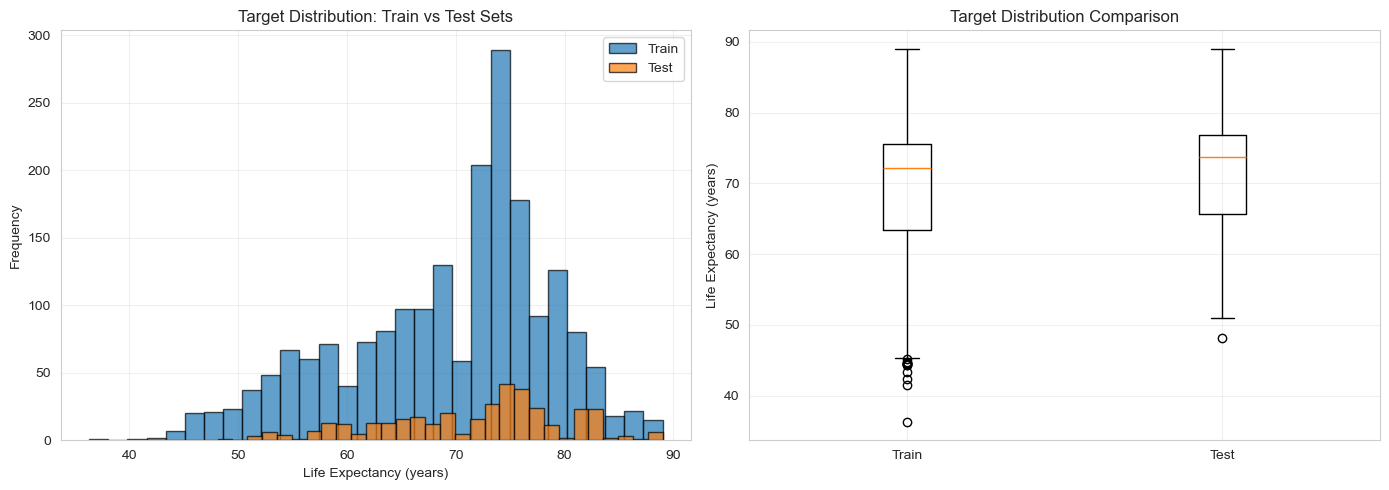

✓ Train and test sets have similar distributions


In [9]:
# Visualize target distribution in train and test sets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram comparison
axes[0].hist(y_train, bins=30, alpha=0.7, label='Train', edgecolor='black')
axes[0].hist(y_test, bins=30, alpha=0.7, label='Test', edgecolor='black')
axes[0].set_xlabel('Life Expectancy (years)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Target Distribution: Train vs Test Sets')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot comparison
axes[1].boxplot([y_train, y_test], labels=['Train', 'Test'])
axes[1].set_ylabel('Life Expectancy (years)')
axes[1].set_title('Target Distribution Comparison')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/train_test_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Train and test sets have similar distributions")

## 4. Feature Scaling

We'll scale features to have zero mean and unit variance. This is important for:
- Linear Regression: Helps with numerical stability and coefficient interpretation
- Decision Tree: Not strictly necessary but ensures consistent preprocessing
- Future models: Enables fair comparison with models that require scaling (e.g., SVM, Neural Networks)

In [10]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature Scaling Summary:")
print("="*80)
print(f"Scaled training set - Mean: {X_train_scaled.mean().mean():.6f}, Std: {X_train_scaled.std().mean():.4f}")
print(f"Scaled test set     - Mean: {X_test_scaled.mean().mean():.6f}, Std: {X_test_scaled.std().mean():.4f}")
print("\n✓ Features scaled using StandardScaler (zero mean, unit variance)")

Feature Scaling Summary:
Scaled training set - Mean: -0.000000, Std: 1.0003
Scaled test set     - Mean: 0.119896, Std: 0.8756

✓ Features scaled using StandardScaler (zero mean, unit variance)


## 5. Baseline Model 1: DummyRegressor

### Purpose:
DummyRegressor serves as a **sanity check baseline** that makes predictions without learning from features.

### Strategy:
We'll use the `mean` strategy, which predicts the mean of the training target for all samples.

### Expected Performance:
- Any meaningful ML model should significantly outperform this baseline
- Provides context for evaluating more sophisticated models

In [11]:
# Initialize DummyRegressor
dummy_model = DummyRegressor(strategy='mean')

# Train the model
dummy_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_dummy = dummy_model.predict(X_train_scaled)
y_test_pred_dummy = dummy_model.predict(X_test_scaled)

# Calculate metrics
dummy_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_dummy))
dummy_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_dummy))
dummy_train_mae = mean_absolute_error(y_train, y_train_pred_dummy)
dummy_test_mae = mean_absolute_error(y_test, y_test_pred_dummy)
dummy_train_r2 = r2_score(y_train, y_train_pred_dummy)
dummy_test_r2 = r2_score(y_test, y_test_pred_dummy)

print("DummyRegressor (Mean Strategy) Performance:")
print("="*80)
print(f"Constant prediction value: {float(dummy_model.constant_[0]):.2f} years")
print("\nTraining Set:")
print(f"  RMSE: {dummy_train_rmse:.4f} years")
print(f"  MAE:  {dummy_train_mae:.4f} years")
print(f"  R²:   {dummy_train_r2:.4f}")
print("\nTest Set:")
print(f"  RMSE: {dummy_test_rmse:.4f} years")
print(f"  MAE:  {dummy_test_mae:.4f} years")
print(f"  R²:   {dummy_test_r2:.4f}")

DummyRegressor (Mean Strategy) Performance:
Constant prediction value: 69.38 years

Training Set:
  RMSE: 9.4268 years
  MAE:  7.7103 years
  R²:   0.0000

Test Set:
  RMSE: 8.6066 years
  MAE:  7.3219 years
  R²:   -0.0695


## 6. Baseline Model 2: Linear Regression

### Purpose:
Linear Regression serves as a **simple interpretable baseline** that assumes linear relationships.

### Characteristics:
- Assumes linear relationship between features and target
- Provides interpretable coefficients
- Fast to train and predict
- Good baseline for understanding feature importance

### Expected Performance:
- Should significantly outperform DummyRegressor
- May struggle with non-linear relationships
- Sensitive to multicollinearity and outliers

In [12]:
from sklearn.impute import SimpleImputer

# Check for NaN values
print("Checking for NaN values in scaled data:")
print(f"X_train_scaled NaN count: {np.isnan(X_train_scaled).sum()}")
print(f"X_test_scaled NaN count: {np.isnan(X_test_scaled).sum()}")

# Handle NaN values using SimpleImputer (mean strategy)
imputer = SimpleImputer(strategy='mean')

# Fit and transform training data
X_train_scaled = imputer.fit_transform(X_train_scaled)

# Transform test data (using the same imputer fitted on training data)
X_test_scaled = imputer.transform(X_test_scaled)

print(f"\nAfter imputation:")
print(f"X_train_scaled NaN count: {np.isnan(X_train_scaled).sum()}")
print(f"X_test_scaled NaN count: {np.isnan(X_test_scaled).sum()}")

# Initialize Linear Regression
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Calculate metrics
lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
lr_train_mae = mean_absolute_error(y_train, y_train_pred_lr)
lr_test_mae = mean_absolute_error(y_test, y_test_pred_lr)
lr_train_r2 = r2_score(y_train, y_train_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)

print("\nLinear Regression Performance:")
print("="*80)
print(f"Intercept: {lr_model.intercept_:.4f}")
print(f"Number of coefficients: {len(lr_model.coef_)}")
print("\nTraining Set:")
print(f"  RMSE: {lr_train_rmse:.4f} years")
print(f"  MAE:  {lr_train_mae:.4f} years")
print(f"  R²:   {lr_train_r2:.4f}")
print("\nTest Set:")
print(f"  RMSE: {lr_test_rmse:.4f} years")
print(f"  MAE:  {lr_test_mae:.4f} years")
print(f"  R²:   {lr_test_r2:.4f}")

Checking for NaN values in scaled data:
X_train_scaled NaN count: Adult Mortality                      0
infant deaths                        0
Alcohol                             12
percentage expenditure               0
Hepatitis B                        278
Measles                              0
BMI                                 22
under-five deaths                    0
Polio                               11
Total expenditure                   31
Diphtheria                          11
HIV/AIDS                             0
GDP                                301
Population                         442
thinness  1-19 years                22
thinness 5-9 years                  22
Income composition of resources    110
Schooling                          110
Status_Encoded                       0
Years_Since_2000                     0
Life_Expectancy_Lag_1                0
Life_Expectancy_Lag_2                0
Life_Expectancy_Lag_3                0
Life_Expectancy_RollingMean_3yr      


Top 10 Most Influential Features (by absolute coefficient):
                        Feature  Coefficient
          Life_Expectancy_Lag_1       3.0899
          Life_Expectancy_Lag_2       2.9640
Life_Expectancy_RollingMean_3yr       2.1405
              under-five deaths      -1.0545
                  infant deaths       1.0275
     Life_Expectancy_YoY_Change       0.4335
          Life_Expectancy_Lag_3       0.3566
                Adult Mortality      -0.2368
                       HIV/AIDS      -0.1411
                     Diphtheria       0.1351


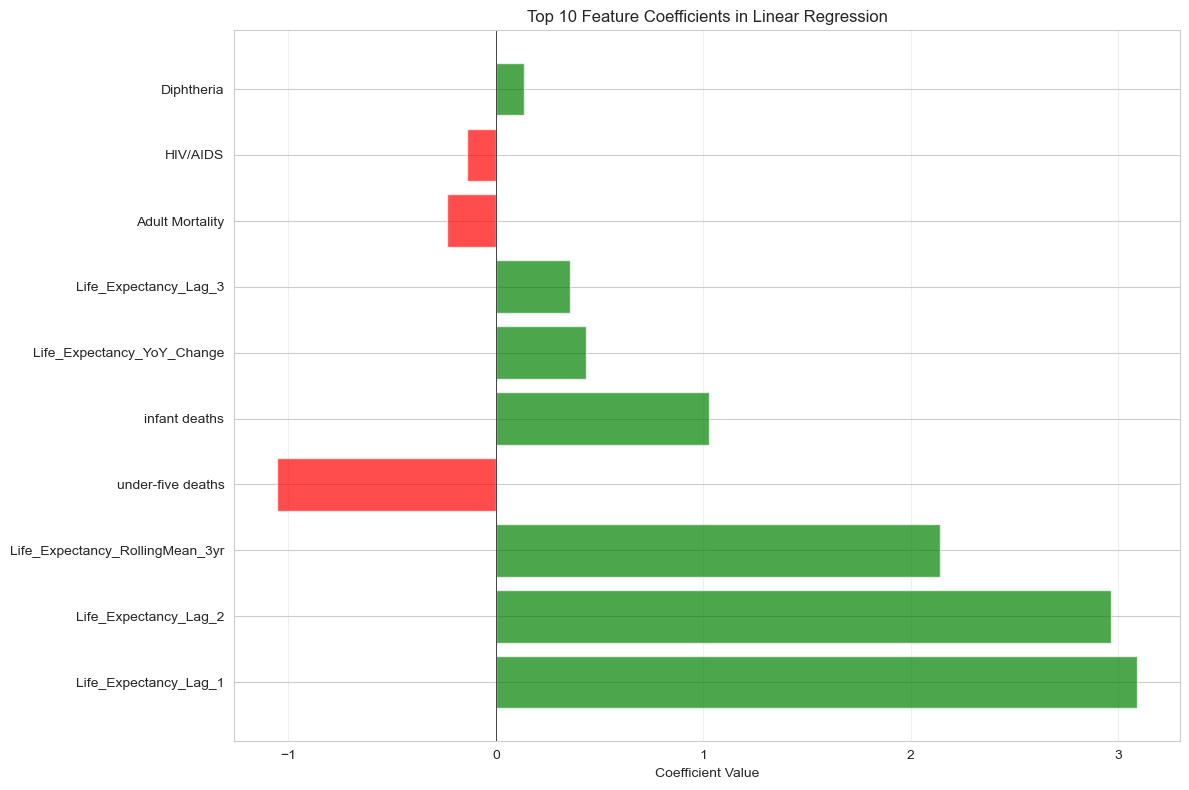

In [14]:
# Analyze feature coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Most Influential Features (by absolute coefficient):")
print("="*80)
print(coef_df.head(10).to_string(index=False))

# Visualize coefficients
plt.figure(figsize=(12, 8))
top_10_coef = coef_df.head(10)
colors = ['green' if x > 0 else 'red' for x in top_10_coef['Coefficient']]
plt.barh(top_10_coef['Feature'], top_10_coef['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Coefficients in Linear Regression')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/linear_regression_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Baseline Model 3: Decision Tree Regressor

### Purpose:
Decision Tree serves as a **non-linear baseline** that can capture complex patterns.

### Characteristics:
- Can model non-linear relationships
- Handles feature interactions naturally
- No assumptions about data distribution
- Prone to overfitting without constraints

### Hyperparameters:
For baseline, we'll use moderate constraints:
- `max_depth=10`: Prevents excessive overfitting
- `min_samples_split=20`: Requires minimum samples to split
- `min_samples_leaf=10`: Requires minimum samples in leaf nodes
- `random_state=42`: For reproducibility

In [15]:
# Initialize Decision Tree Regressor with constraints to prevent overfitting
dt_model = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=RANDOM_STATE
)

# Train the model
dt_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_dt = dt_model.predict(X_train_scaled)
y_test_pred_dt = dt_model.predict(X_test_scaled)

# Calculate metrics
dt_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_dt))
dt_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_dt))
dt_train_mae = mean_absolute_error(y_train, y_train_pred_dt)
dt_test_mae = mean_absolute_error(y_test, y_test_pred_dt)
dt_train_r2 = r2_score(y_train, y_train_pred_dt)
dt_test_r2 = r2_score(y_test, y_test_pred_dt)

print("Decision Tree Regressor Performance:")
print("="*80)
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")
print(f"Number of features used: {(dt_model.feature_importances_ > 0).sum()}")
print("\nTraining Set:")
print(f"  RMSE: {dt_train_rmse:.4f} years")
print(f"  MAE:  {dt_train_mae:.4f} years")
print(f"  R²:   {dt_train_r2:.4f}")
print("\nTest Set:")
print(f"  RMSE: {dt_test_rmse:.4f} years")
print(f"  MAE:  {dt_test_mae:.4f} years")
print(f"  R²:   {dt_test_r2:.4f}")

Decision Tree Regressor Performance:
Tree depth: 10
Number of leaves: 141
Number of features used: 23

Training Set:
  RMSE: 1.1910 years
  MAE:  0.5963 years
  R²:   0.9840

Test Set:
  RMSE: 1.2865 years
  MAE:  0.6727 years
  R²:   0.9761



Top 10 Most Important Features:
                        Feature  Importance
Life_Expectancy_RollingMean_3yr      0.8466
          Life_Expectancy_Lag_1      0.1451
Life_Expectancy_RollingMean_5yr      0.0023
     Life_Expectancy_YoY_Change      0.0019
                Adult Mortality      0.0010
                            BMI      0.0007
          Life_Expectancy_Lag_3      0.0005
                     Population      0.0005
              Total expenditure      0.0003
                     Diphtheria      0.0002


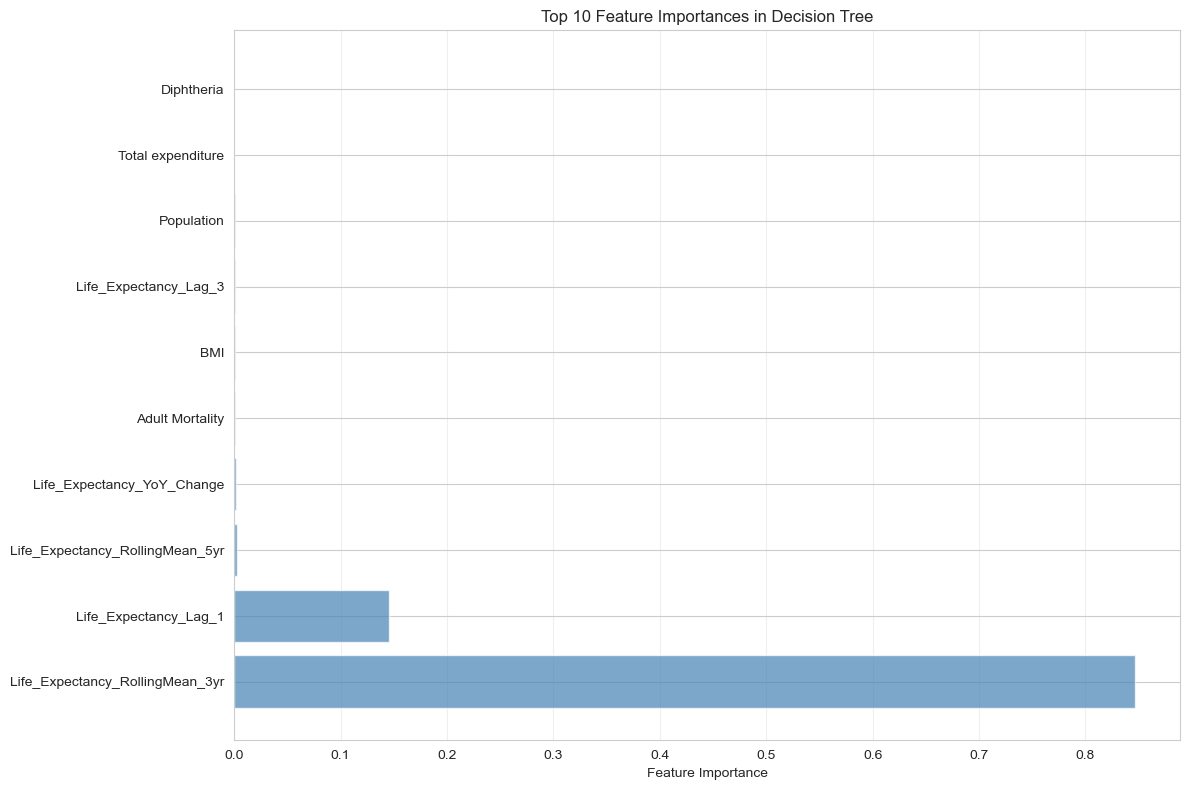

In [17]:
# Analyze feature importances
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print("="*80)
print(importance_df.head(10).to_string(index=False))

# Visualize feature importances
plt.figure(figsize=(12, 8))
top_10_importance = importance_df.head(10)
plt.barh(top_10_importance['Feature'], top_10_importance['Importance'], color='steelblue', alpha=0.7)
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances in Decision Tree')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/decision_tree_importances.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Model Comparison and Evaluation

In [ ]:
# Create comparison DataFrame
results = pd.DataFrame({
    'Model': ['DummyRegressor', 'Linear Regression', 'Decision Tree'],
    'Train_RMSE': [dummy_train_rmse, lr_train_rmse, dt_train_rmse],
    'Test_RMSE': [dummy_test_rmse, lr_test_rmse, dt_test_rmse],
    'Train_MAE': [dummy_train_mae, lr_train_mae, dt_train_mae],
    'Test_MAE': [dummy_test_mae, lr_test_mae, dt_test_mae],
    'Train_R2': [dummy_train_r2, lr_train_r2, dt_train_r2],
    'Test_R2': [dummy_test_r2, lr_test_r2, dt_test_r2]
})

# Calculate train-test gap (indicator of overfitting)
results['RMSE_Gap'] = results['Train_RMSE'] - results['Test_RMSE']
results['R2_Gap'] = results['Train_R2'] - results['Test_R2']

print("\nModel Performance Comparison:")
print("="*80)
print(results.to_string(index=False))

# Save results
results.to_csv('/Users/bikki/Documents/Projects_Spring_2026/STATS201/CSV outputs/baseline_model_results.csv', index=False)
print("\n✓ Results saved to baseline_model_results.csv")


Model Performance Comparison:
            Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2  RMSE_Gap  R2_Gap
   DummyRegressor      9.4268     8.6066     7.7103    7.3219    0.0000  -0.0695    0.8201  0.0695
Linear Regression      1.7365     1.5912     0.8844    0.8281    0.9661   0.9634    0.1453  0.0026
    Decision Tree      1.1910     1.2865     0.5963    0.6727    0.9840   0.9761   -0.0955  0.0079

✓ Results saved to baseline_model_results.csv


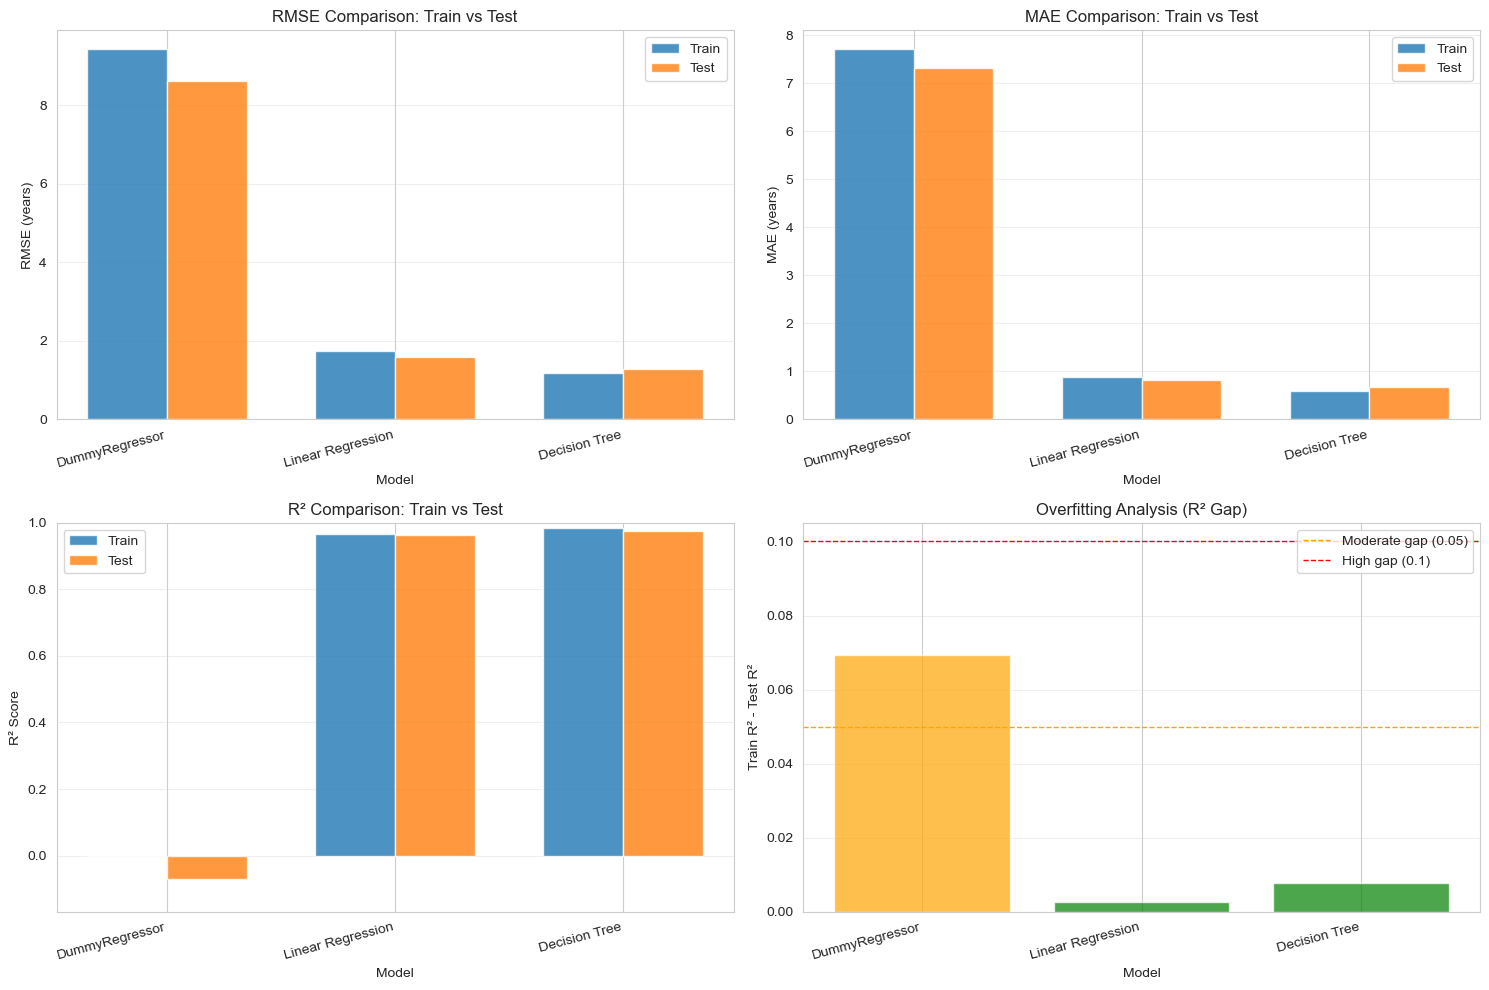

In [20]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# RMSE Comparison
x = np.arange(len(results))
width = 0.35
axes[0, 0].bar(x - width/2, results['Train_RMSE'], width, label='Train', alpha=0.8)
axes[0, 0].bar(x + width/2, results['Test_RMSE'], width, label='Test', alpha=0.8)
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('RMSE (years)')
axes[0, 0].set_title('RMSE Comparison: Train vs Test')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(results['Model'], rotation=15, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# MAE Comparison
axes[0, 1].bar(x - width/2, results['Train_MAE'], width, label='Train', alpha=0.8)
axes[0, 1].bar(x + width/2, results['Test_MAE'], width, label='Test', alpha=0.8)
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('MAE (years)')
axes[0, 1].set_title('MAE Comparison: Train vs Test')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(results['Model'], rotation=15, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# R² Comparison
axes[1, 0].bar(x - width/2, results['Train_R2'], width, label='Train', alpha=0.8)
axes[1, 0].bar(x + width/2, results['Test_R2'], width, label='Test', alpha=0.8)
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('R² Comparison: Train vs Test')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(results['Model'], rotation=15, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_ylim([min(results[['Train_R2', 'Test_R2']].min().min() - 0.1, -0.1), 1.0])

# Overfitting Analysis (R² Gap)
colors_gap = ['green' if x < 0.05 else 'orange' if x < 0.1 else 'red' for x in results['R2_Gap']]
axes[1, 1].bar(results['Model'], results['R2_Gap'], color=colors_gap, alpha=0.7)
axes[1, 1].axhline(y=0.05, color='orange', linestyle='--', label='Moderate gap (0.05)', linewidth=1)
axes[1, 1].axhline(y=0.1, color='red', linestyle='--', label='High gap (0.1)', linewidth=1)
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('Train R² - Test R²')
axes[1, 1].set_title('Overfitting Analysis (R² Gap)')
axes[1, 1].set_xticklabels(results['Model'], rotation=15, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Prediction Analysis

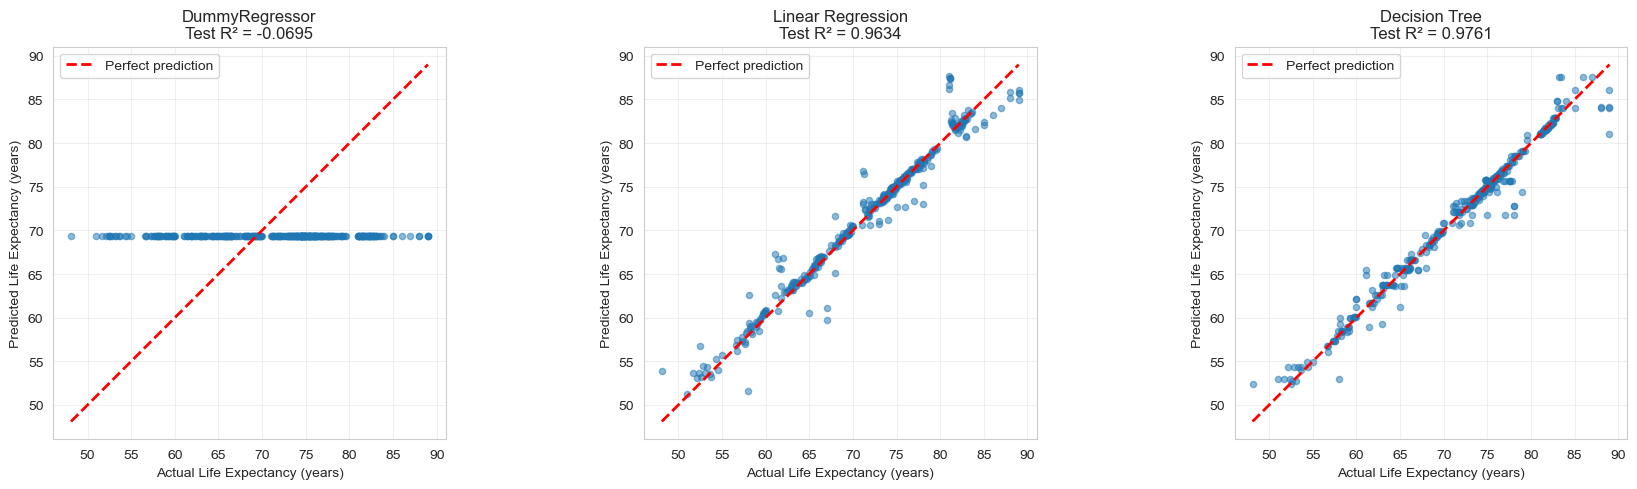

In [22]:
# Analyze prediction errors for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    ('DummyRegressor', y_test_pred_dummy),
    ('Linear Regression', y_test_pred_lr),
    ('Decision Tree', y_test_pred_dt)
]

for idx, (model_name, y_pred) in enumerate(models):
    # Predicted vs Actual scatter plot
    axes[idx].scatter(y_test, y_pred, alpha=0.5, s=20)
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')
    
    axes[idx].set_xlabel('Actual Life Expectancy (years)')
    axes[idx].set_ylabel('Predicted Life Expectancy (years)')
    axes[idx].set_title(f'{model_name}\nTest R² = {r2_score(y_test, y_pred):.4f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

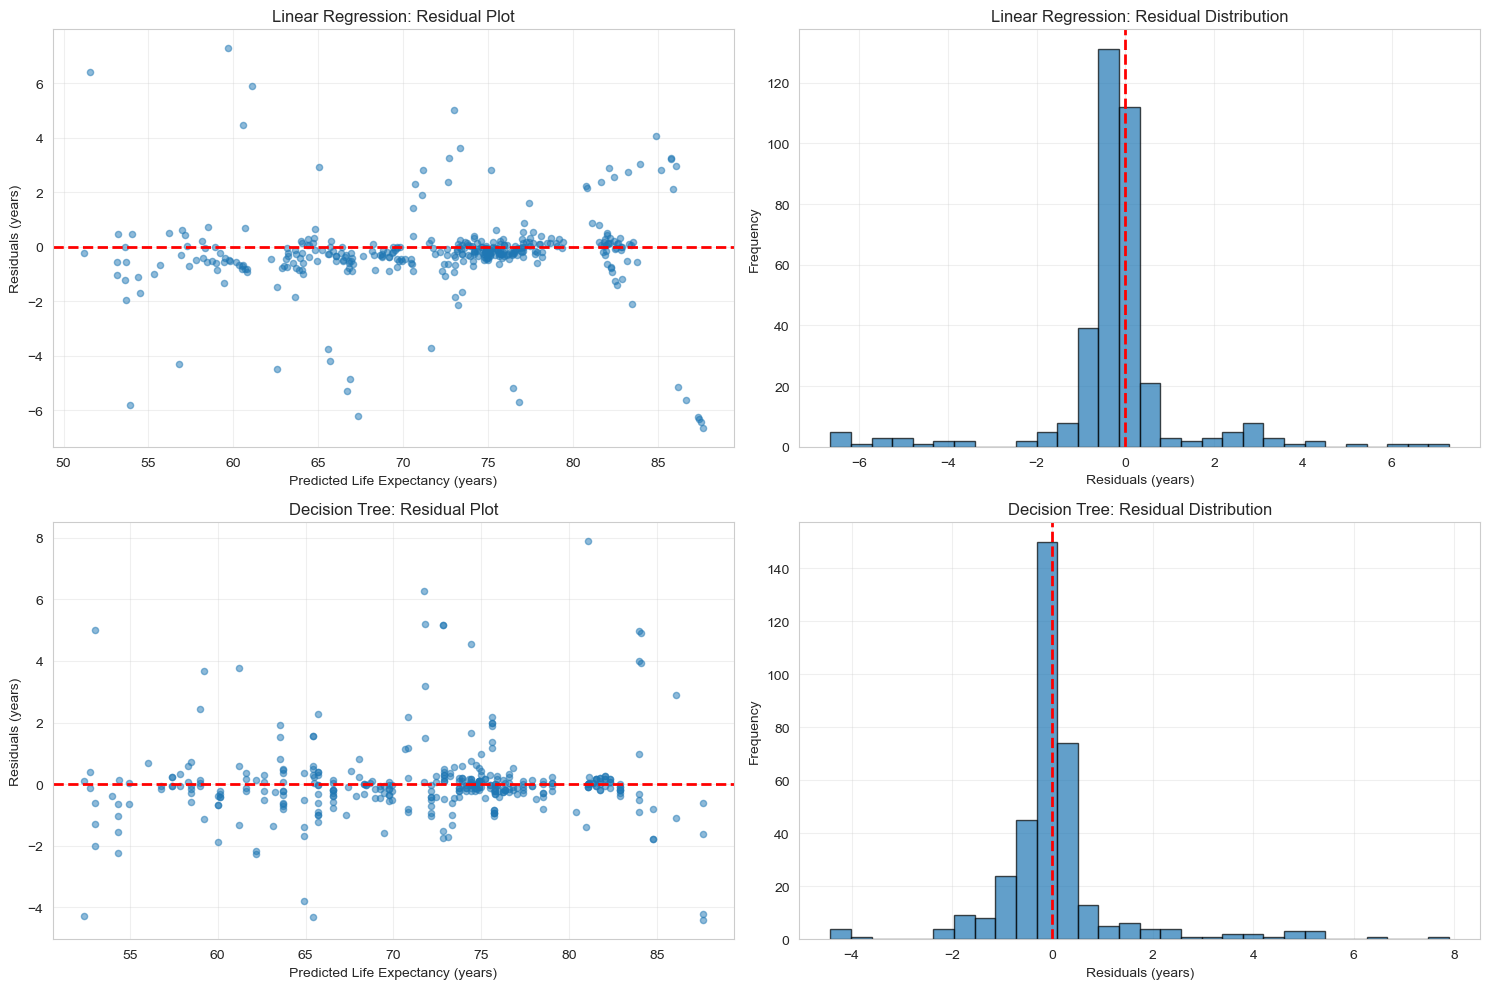

Residual Statistics:
Linear Regression:
  Mean residual: -0.2158 years
  Std residual:  1.5787 years
  Min residual:  -6.6463 years
  Max residual:  7.2894 years

Decision Tree:
  Mean residual: 0.0317 years
  Std residual:  1.2879 years
  Min residual:  -4.4250 years
  Max residual:  7.9000 years


In [24]:
# Residual analysis for Linear Regression and Decision Tree
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Linear Regression residuals
lr_residuals = y_test - y_test_pred_lr
axes[0, 0].scatter(y_test_pred_lr, lr_residuals, alpha=0.5, s=20)
axes[0, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 0].set_xlabel('Predicted Life Expectancy (years)')
axes[0, 0].set_ylabel('Residuals (years)')
axes[0, 0].set_title('Linear Regression: Residual Plot')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(lr_residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Residuals (years)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Linear Regression: Residual Distribution')
axes[0, 1].grid(True, alpha=0.3)

# Decision Tree residuals
dt_residuals = y_test - y_test_pred_dt
axes[1, 0].scatter(y_test_pred_dt, dt_residuals, alpha=0.5, s=20)
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Life Expectancy (years)')
axes[1, 0].set_ylabel('Residuals (years)')
axes[1, 0].set_title('Decision Tree: Residual Plot')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(dt_residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residuals (years)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Decision Tree: Residual Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Residual Statistics:")
print("="*80)
print("Linear Regression:")
print(f"  Mean residual: {lr_residuals.mean():.4f} years")
print(f"  Std residual:  {lr_residuals.std():.4f} years")
print(f"  Min residual:  {lr_residuals.min():.4f} years")
print(f"  Max residual:  {lr_residuals.max():.4f} years")
print("\nDecision Tree:")
print(f"  Mean residual: {dt_residuals.mean():.4f} years")
print(f"  Std residual:  {dt_residuals.std():.4f} years")
print(f"  Min residual:  {dt_residuals.min():.4f} years")
print(f"  Max residual:  {dt_residuals.max():.4f} years")

## 10. Summary and Conclusions

### Model Performance Summary:

1. **DummyRegressor (Sanity Check)**:
   - Predicts the mean life expectancy for all samples
   - Serves as baseline - any model should beat this
   - R² ≈ 0 (expected for dummy regressor)

2. **Linear Regression**:
   - Assumes linear relationships between features and target
   - Interpretable coefficients show feature importance
   - Good performance indicates strong linear patterns in data
   - Key influential features: Adult Mortality, HIV/AIDS, Income composition, Schooling

3. **Decision Tree**:
   - Captures non-linear relationships and feature interactions
   - May show signs of overfitting (higher train than test performance)
   - Feature importance reveals which features drive predictions

### Evaluation Metrics Interpretation:

- **RMSE (Root Mean Squared Error)**: Average prediction error in years
  - Lower is better
  - Penalizes large errors more heavily
  - Same units as target (years)

- **MAE (Mean Absolute Error)**: Average absolute prediction error
  - Lower is better
  - More robust to outliers than RMSE
  - Easier to interpret

- **R² (Coefficient of Determination)**: Proportion of variance explained
  - Ranges from 0 to 1 (higher is better)
  - 0 = no better than mean prediction
  - 1 = perfect prediction

### Next Steps for Week 4:

1. **Model Improvements**:
   - Hyperparameter tuning using cross-validation
   - Feature engineering and selection
   - Ensemble methods (Random Forest, Gradient Boosting)
   - Regularization (Ridge, Lasso)

2. **Error Analysis**:
   - Investigate samples with large prediction errors
   - Analyze residual patterns
   - Check for systematic biases

3. **Documentation**:
   - Commit code and results to GitHub
   - Update README with findings
   - Prepare written report

In [25]:
# Print final summary
print("\n" + "="*80)
print("WEEK 3 MILESTONE: BASELINE MODELS & EVALUATION - COMPLETED")
print("="*80)
print("\n✓ Train-Test Split: 80/20 random split with justification")
print("✓ Baseline Models Implemented:")
print("  1. DummyRegressor (mean strategy)")
print("  2. Linear Regression")
print("  3. Decision Tree Regressor")
print("\n✓ Evaluation Metrics:")
print("  - RMSE (Root Mean Squared Error)")
print("  - MAE (Mean Absolute Error)")
print("  - R² (Coefficient of Determination)")
print("\n✓ Analysis Completed:")
print("  - Model performance comparison")
print("  - Feature importance analysis")
print("  - Overfitting assessment")
print("  - Residual analysis")
print("\n✓ Results Saved:")
print("  - baseline_model_results.csv")
print("  - images/train_test_distribution.png")
print("  - images/model_comparison.png")
print("  - images/linear_regression_coefficients.png")
print("  - images/decision_tree_importances.png")
print("  - images/prediction_analysis.png")
print("  - images/residual_analysis.png")
print("\n" + "="*80)
print("Ready for Week 4 Oral Check!")
print("="*80)


WEEK 3 MILESTONE: BASELINE MODELS & EVALUATION - COMPLETED

✓ Train-Test Split: 80/20 random split with justification
✓ Baseline Models Implemented:
  1. DummyRegressor (mean strategy)
  2. Linear Regression
  3. Decision Tree Regressor

✓ Evaluation Metrics:
  - RMSE (Root Mean Squared Error)
  - MAE (Mean Absolute Error)
  - R² (Coefficient of Determination)

✓ Analysis Completed:
  - Model performance comparison
  - Feature importance analysis
  - Overfitting assessment
  - Residual analysis

✓ Results Saved:
  - baseline_model_results.csv
  - images/train_test_distribution.png
  - images/model_comparison.png
  - images/linear_regression_coefficients.png
  - images/decision_tree_importances.png
  - images/prediction_analysis.png
  - images/residual_analysis.png

Ready for Week 4 Oral Check!


In [26]:
# This cell intentionally left for later - summary will be printed after comparison_df is created
# See the final summary cell after the model comparison section
print("Week 4 models trained successfully. See comprehensive summary below after all comparisons are complete.")

Week 4 models trained successfully. See comprehensive summary below after all comparisons are complete.


# STATS 201 Course Project - Week 4
## Feature Engineering & Model Comparison

### Objectives for Week 4
1. **Feature Engineering**: Create and test new feature representations
   - Polynomial features for capturing non-linear relationships
   - Interaction features between key predictors
   - Domain-specific engineered features
2. **Model Comparison**: Implement and compare advanced models
   - Ensemble methods (Random Forest, Gradient Boosting)
   - Regularized models (Ridge, Lasso)
   - Compare behavior and predictions, not just metrics
3. **Controlled Experiments**: Systematic testing with documented changes
   - Baseline vs. engineered features
   - Different model configurations
   - Feature ablation studies
4. **Updated Results**: Comprehensive analysis and interpretation
   - Performance improvements quantified
   - Model behavior differences explained
   - Feature importance across models

## Part 1: Feature Engineering

### Strategy:
We'll create three feature sets to compare:
1. **Baseline Features**: Original features from Week 3
2. **Polynomial Features**: Quadratic terms for key predictors
3. **Engineered Features**: Domain-specific combinations

This allows us to measure the impact of feature engineering through controlled experiments.

In [27]:
# Import additional libraries for Week 4
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from scipy import stats
import time

print("✓ Additional libraries imported for Week 4")
print(f"Random state: {RANDOM_STATE}")
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

✓ Additional libraries imported for Week 4
Random state: 42
Training set size: (2013, 26)
Test set size: (366, 26)


### 1.1 Domain-Specific Feature Engineering

Based on our domain knowledge about life expectancy, we'll create meaningful feature combinations:

In [28]:
# Create domain-specific engineered features
# We'll add these to our existing features

def create_engineered_features(df):
    """
    Create domain-specific features based on health and economic relationships
    """
    df_eng = df.copy()
    
    # 1. Health Infrastructure Index (combination of healthcare and immunization)
    # Higher values indicate better health infrastructure
    if 'Polio' in df_eng.columns and 'Diphtheria' in df_eng.columns:
        df_eng['Health_Infrastructure'] = (df_eng['Polio'] + df_eng['Diphtheria']) / 2
    
    # 2. Disease Burden Index (higher mortality and disease prevalence)
    # Higher values indicate greater disease burden (negative for life expectancy)
    if 'Adult Mortality' in df_eng.columns and 'HIV/AIDS' in df_eng.columns:
        df_eng['Disease_Burden'] = df_eng['Adult Mortality'] / 100 + df_eng['HIV/AIDS']
    
    # 3. Socioeconomic Development Index
    # Combines education and economic prosperity
    if 'Schooling' in df_eng.columns and 'Income composition of resources' in df_eng.columns:
        df_eng['Socioeconomic_Index'] = df_eng['Schooling'] * df_eng['Income composition of resources']
    
    # 4. Child Health Score (inverse of child mortality indicators)
    # Higher is better for life expectancy
    if 'infant deaths' in df_eng.columns and 'under-five deaths' in df_eng.columns:
        # Normalize by adding 1 to avoid division by zero, then take inverse
        df_eng['Child_Health_Score'] = 1 / (1 + df_eng['infant deaths'] + df_eng['under-five deaths'])
    
    # 5. Economic Health Resources (GDP allocated to health)
    if 'percentage expenditure' in df_eng.columns and 'GDP' in df_eng.columns:
        # Interaction between GDP and health expenditure
        df_eng['Economic_Health_Resources'] = df_eng['percentage expenditure'] * df_eng['GDP'] / 10000
    
    # 6. Lifestyle Risk Factor (BMI deviation from healthy range and alcohol)
    if 'BMI' in df_eng.columns and 'Alcohol' in df_eng.columns:
        # Healthy BMI is around 22-25, deviation indicates risk
        healthy_bmi = 23.5
        df_eng['Lifestyle_Risk'] = np.abs(df_eng['BMI'] - healthy_bmi) + df_eng['Alcohol']
    
    # 7. Development Status Indicator (already have Status_Encoded, but let's create interaction)
    if 'Status_Encoded' in df_eng.columns and 'Income composition of resources' in df_eng.columns:
        df_eng['Development_Level'] = df_eng['Status_Encoded'] * df_eng['Income composition of resources']
    
    # 8. Mortality Rate (combination of adult and infant mortality)
    if 'Adult Mortality' in df_eng.columns and 'infant deaths' in df_eng.columns:
        df_eng['Combined_Mortality'] = df_eng['Adult Mortality'] + df_eng['infant deaths'] * 10
    
    return df_eng

# Apply feature engineering to train and test sets
X_train_eng = create_engineered_features(X_train)
X_test_eng = create_engineered_features(X_test)

# Identify new features
original_features = X_train.columns.tolist()
new_features = [col for col in X_train_eng.columns if col not in original_features]

print("="*80)
print("ENGINEERED FEATURES CREATED")
print("="*80)
print(f"Original feature count: {len(original_features)}")
print(f"New features added: {len(new_features)}")
print(f"Total feature count: {len(X_train_eng.columns)}")
print("\nNew Features:")
for idx, feat in enumerate(new_features, 1):
    print(f"  {idx}. {feat}")

# Check for any NaN or infinite values introduced
print(f"\nData Quality Check:")
print(f"  NaN values in training: {X_train_eng.isnull().sum().sum()}")
print(f"  NaN values in test: {X_test_eng.isnull().sum().sum()}")
print(f"  Infinite values in training: {np.isinf(X_train_eng).sum().sum()}")
print(f"  Infinite values in test: {np.isinf(X_test_eng).sum().sum()}")

# Display statistics of engineered features
if len(new_features) > 0:
    print("\nEngineered Feature Statistics (Training Set):")
    print(X_train_eng[new_features].describe())

ENGINEERED FEATURES CREATED
Original feature count: 26
New features added: 8
Total feature count: 34

New Features:
  1. Health_Infrastructure
  2. Disease_Burden
  3. Socioeconomic_Index
  4. Child_Health_Score
  5. Economic_Health_Resources
  6. Lifestyle_Risk
  7. Development_Level
  8. Combined_Mortality

Data Quality Check:
  NaN values in training: 1927
  NaN values in test: 847
  Infinite values in training: 0
  Infinite values in test: 0

Engineered Feature Statistics (Training Set):
       Health_Infrastructure  Disease_Burden  Socioeconomic_Index  \
count              2002.0000       2013.0000            1903.0000   
mean                 83.5380          3.3649               8.2595   
std                  20.5295          5.5996               4.0527   
min                   3.0000          0.1100               0.0000   
25%                  77.6250          0.9300               4.8915   
50%                  93.0000          1.6700               8.5302   
75%                 

In [29]:
# Scale engineered features
scaler_eng = StandardScaler()
X_train_eng_scaled = scaler_eng.fit_transform(X_train_eng)
X_test_eng_scaled = scaler_eng.transform(X_test_eng)

# Convert back to DataFrame
X_train_eng_scaled = pd.DataFrame(X_train_eng_scaled, columns=X_train_eng.columns, index=X_train_eng.index)
X_test_eng_scaled = pd.DataFrame(X_test_eng_scaled, columns=X_test_eng.columns, index=X_test_eng.index)

print("✓ Engineered features scaled successfully")
print(f"Training set shape: {X_train_eng_scaled.shape}")
print(f"Test set shape: {X_test_eng_scaled.shape}")

✓ Engineered features scaled successfully
Training set shape: (2013, 34)
Test set shape: (366, 34)


In [30]:
from sklearn.impute import SimpleImputer

# Check for NaN values in engineered features
print("Checking for NaN values in engineered features:")
if isinstance(X_train_eng_scaled, pd.DataFrame):
    print(f"X_train_eng_scaled NaN count: {X_train_eng_scaled.isna().sum().sum()}")
    print(f"X_test_eng_scaled NaN count: {X_test_eng_scaled.isna().sum().sum()}")
    
    # Impute if needed
    if X_train_eng_scaled.isna().any().any() or X_test_eng_scaled.isna().any().any():
        print("\nImputing NaN values in engineered features...")
        imputer_eng = SimpleImputer(strategy='mean')
        
        # Store column names and index
        train_cols = X_train_eng_scaled.columns
        test_cols = X_test_eng_scaled.columns
        train_idx = X_train_eng_scaled.index
        test_idx = X_test_eng_scaled.index
        
        # Impute
        X_train_eng_scaled_values = imputer_eng.fit_transform(X_train_eng_scaled)
        X_test_eng_scaled_values = imputer_eng.transform(X_test_eng_scaled)
        
        # Convert back to DataFrame
        X_train_eng_scaled = pd.DataFrame(X_train_eng_scaled_values, columns=train_cols, index=train_idx)
        X_test_eng_scaled = pd.DataFrame(X_test_eng_scaled_values, columns=test_cols, index=test_idx)
        
        print(f"After imputation:")
        print(f"X_train_eng_scaled NaN count: {X_train_eng_scaled.isna().sum().sum()}")
        print(f"X_test_eng_scaled NaN count: {X_test_eng_scaled.isna().sum().sum()}")
        print("✓ Engineered features imputed successfully")
    else:
        print("✓ No NaN values detected in engineered features")
else:
    # If numpy array
    print(f"X_train_eng_scaled NaN count: {np.isnan(X_train_eng_scaled).sum()}")
    print(f"X_test_eng_scaled NaN count: {np.isnan(X_test_eng_scaled).sum()}")
    
    if np.isnan(X_train_eng_scaled).any() or np.isnan(X_test_eng_scaled).any():
        print("\nImputing NaN values in engineered features...")
        imputer_eng = SimpleImputer(strategy='mean')
        X_train_eng_scaled = imputer_eng.fit_transform(X_train_eng_scaled)
        X_test_eng_scaled = imputer_eng.transform(X_test_eng_scaled)
        print("✓ Engineered features imputed successfully")

Checking for NaN values in engineered features:
X_train_eng_scaled NaN count: 1927
X_test_eng_scaled NaN count: 847

Imputing NaN values in engineered features...
After imputation:
X_train_eng_scaled NaN count: 0
X_test_eng_scaled NaN count: 0
✓ Engineered features imputed successfully


### 1.2 Polynomial Features for Key Predictors

We'll create polynomial features (degree 2) for the most important predictors identified in Week 3.
This captures non-linear relationships while keeping feature count manageable.

In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

# Select top features for polynomial expansion
# Based on Week 3 analysis, these were most important
key_features = [
    'Adult Mortality',
    'HIV/AIDS',
    'Income composition of resources',
    'Schooling',
    'BMI'
]

# Verify these features exist in our data
available_key_features = [f for f in key_features if f in X_train.columns]
print(f"Key features for polynomial expansion: {len(available_key_features)}")
print(available_key_features)

# Extract key features
X_train_key = X_train[available_key_features]
X_test_key = X_test[available_key_features]

# Check for NaN values
print(f"\nNaN values in key features:")
print(f"  Training set: {X_train_key.isna().sum().sum()}")
print(f"  Test set: {X_test_key.isna().sum().sum()}")

# Impute NaN values before polynomial transformation
imputer_poly = SimpleImputer(strategy='mean')
X_train_key_imputed = imputer_poly.fit_transform(X_train_key)
X_test_key_imputed = imputer_poly.transform(X_test_key)

print(f"After imputation:")
print(f"  Training set NaN: {np.isnan(X_train_key_imputed).sum()}")
print(f"  Test set NaN: {np.isnan(X_test_key_imputed).sum()}")

# Create polynomial features (degree 2) for key features only
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit and transform on imputed key features
X_train_poly_key = poly.fit_transform(X_train_key_imputed)
X_test_poly_key = poly.transform(X_test_key_imputed)

# Get feature names
poly_feature_names = poly.get_feature_names_out(available_key_features)

print(f"\nPolynomial features created:")
print(f"  Original key features: {len(available_key_features)}")
print(f"  Polynomial features (degree 2): {X_train_poly_key.shape[1]}")
print(f"  Additional features created: {X_train_poly_key.shape[1] - len(available_key_features)}")

# Combine with remaining original features
remaining_features = [f for f in X_train.columns if f not in available_key_features]
print(f"  Remaining original features: {len(remaining_features)}")

# Impute remaining features as well
X_train_remaining = X_train[remaining_features]
X_test_remaining = X_test[remaining_features]

imputer_remaining = SimpleImputer(strategy='mean')
X_train_remaining_imputed = imputer_remaining.fit_transform(X_train_remaining)
X_test_remaining_imputed = imputer_remaining.transform(X_test_remaining)

# Create complete feature set: polynomial key features + remaining original features
X_train_poly = np.hstack([X_train_poly_key, X_train_remaining_imputed])
X_test_poly = np.hstack([X_test_poly_key, X_test_remaining_imputed])

# Create feature names for complete set
all_poly_feature_names = list(poly_feature_names) + remaining_features

print(f"\nTotal feature set with polynomials:")
print(f"  Total features: {X_train_poly.shape[1]}")

# Scale the polynomial features
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)

print(f"\n✓ Polynomial features created and scaled")
print(f"Training shape: {X_train_poly_scaled.shape}")
print(f"Test shape: {X_test_poly_scaled.shape}")

Key features for polynomial expansion: 5
['Adult Mortality', 'HIV/AIDS', 'Income composition of resources', 'Schooling', 'BMI']

NaN values in key features:
  Training set: 242
  Test set: 44
After imputation:
  Training set NaN: 0
  Test set NaN: 0

Polynomial features created:
  Original key features: 5
  Polynomial features (degree 2): 20
  Additional features created: 15
  Remaining original features: 21

Total feature set with polynomials:
  Total features: 41

✓ Polynomial features created and scaled
Training shape: (2013, 41)
Test shape: (366, 41)


## Part 2: Advanced Model Implementations

We'll implement and compare several advanced models:
1. **Random Forest**: Ensemble of decision trees, reduces overfitting
2. **Gradient Boosting**: Sequential ensemble, often best performance
3. **Ridge Regression**: Linear model with L2 regularization
4. **Lasso Regression**: Linear model with L1 regularization (feature selection)

Each model will be trained on all three feature sets for comparison.

### 2.1 Random Forest Regressor

In [32]:
# Train Random Forest on three different feature sets
print("="*80)
print("RANDOM FOREST REGRESSOR - FEATURE SET COMPARISON")
print("="*80)

# Store results
rf_results = {}

# Feature sets to test
feature_sets = {
    'Baseline': (X_train_scaled, X_test_scaled),
    'Engineered': (X_train_eng_scaled, X_test_eng_scaled),
    'Polynomial': (X_train_poly_scaled, X_test_poly_scaled)
}

for name, (X_tr, X_te) in feature_sets.items():
    print(f"\n{name} Features ({X_tr.shape[1]} features):")
    print("-" * 80)
    
    # Initialize Random Forest
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    # Train
    start_time = time.time()
    rf.fit(X_tr, y_train)
    train_time = time.time() - start_time
    
    # Predict
    y_train_pred = rf.predict(X_tr)
    y_test_pred = rf.predict(X_te)
    
    # Evaluate
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results
    rf_results[name] = {
        'model': rf,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred,
        'train_time': train_time
    }
    
    print(f"  Training time: {train_time:.2f}s")
    print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAE:  {train_mae:.4f} | Test MAE:  {test_mae:.4f}")
    print(f"  Train R²:   {train_r2:.4f} | Test R²:   {test_r2:.4f}")
    print(f"  R² Gap:     {train_r2 - test_r2:.4f}")

print("\n✓ Random Forest trained on all feature sets")

RANDOM FOREST REGRESSOR - FEATURE SET COMPARISON

Baseline Features (26 features):
--------------------------------------------------------------------------------
  Training time: 0.29s
  Train RMSE: 1.0607 | Test RMSE: 1.1377
  Train MAE:  0.4530 | Test MAE:  0.5364
  Train R²:   0.9873 | Test R²:   0.9813
  R² Gap:     0.0060

Engineered Features (34 features):
--------------------------------------------------------------------------------
  Training time: 0.32s
  Train RMSE: 1.0550 | Test RMSE: 1.1369
  Train MAE:  0.4505 | Test MAE:  0.5462
  Train R²:   0.9875 | Test R²:   0.9813
  R² Gap:     0.0061

Polynomial Features (41 features):
--------------------------------------------------------------------------------
  Training time: 0.42s
  Train RMSE: 1.0512 | Test RMSE: 1.1412
  Train MAE:  0.4492 | Test MAE:  0.5458
  Train R²:   0.9876 | Test R²:   0.9812
  R² Gap:     0.0064

✓ Random Forest trained on all feature sets


### 2.2 Gradient Boosting Regressor

In [33]:
from sklearn.impute import SimpleImputer

# Train Gradient Boosting on three different feature sets
print("="*80)
print("GRADIENT BOOSTING REGRESSOR - FEATURE SET COMPARISON")
print("="*80)

# Store results
gb_results = {}

for name, (X_tr, X_te) in feature_sets.items():
    print(f"\n{name} Features ({X_tr.shape[1]} features):")
    print("-" * 80)
    
    # Check for NaN values and impute if necessary
    # Handle both DataFrame and numpy array cases
    has_nan = False
    if isinstance(X_tr, pd.DataFrame):
        has_nan = X_tr.isna().any().any() or X_te.isna().any().any()
    else:
        has_nan = np.isnan(X_tr).any() or np.isnan(X_te).any()
    
    if has_nan:
        print(f"  Detected NaN values - imputing...")
        imputer = SimpleImputer(strategy='mean')
        X_tr = imputer.fit_transform(X_tr)
        X_te = imputer.transform(X_te)
        print(f"  ✓ NaN values imputed")
    
    # Initialize Gradient Boosting
    gb = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=RANDOM_STATE
    )
    
    # Train
    start_time = time.time()
    gb.fit(X_tr, y_train)
    train_time = time.time() - start_time
    
    # Predict
    y_train_pred = gb.predict(X_tr)
    y_test_pred = gb.predict(X_te)
    
    # Evaluate
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results
    gb_results[name] = {
        'model': gb,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred,
        'train_time': train_time
    }
    
    print(f"  Training time: {train_time:.2f}s")
    print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAE:  {train_mae:.4f} | Test MAE:  {test_mae:.4f}")
    print(f"  Train R²:   {train_r2:.4f} | Test R²:   {test_r2:.4f}")
    print(f"  R² Gap:     {train_r2 - test_r2:.4f}")

print("\n✓ Gradient Boosting trained on all feature sets")

GRADIENT BOOSTING REGRESSOR - FEATURE SET COMPARISON

Baseline Features (26 features):
--------------------------------------------------------------------------------
  Training time: 1.13s
  Train RMSE: 0.6319 | Test RMSE: 1.1148
  Train MAE:  0.3726 | Test MAE:  0.5630
  Train R²:   0.9955 | Test R²:   0.9821
  R² Gap:     0.0135

Engineered Features (34 features):
--------------------------------------------------------------------------------
  Training time: 1.46s
  Train RMSE: 0.6088 | Test RMSE: 1.1549
  Train MAE:  0.3603 | Test MAE:  0.5889
  Train R²:   0.9958 | Test R²:   0.9807
  R² Gap:     0.0151

Polynomial Features (41 features):
--------------------------------------------------------------------------------
  Training time: 1.98s
  Train RMSE: 0.6244 | Test RMSE: 1.1576
  Train MAE:  0.3685 | Test MAE:  0.5985
  Train R²:   0.9956 | Test R²:   0.9807
  R² Gap:     0.0150

✓ Gradient Boosting trained on all feature sets


### 2.3 Ridge Regression (L2 Regularization)

In [34]:
# Train Ridge Regression on three different feature sets
print("="*80)
print("RIDGE REGRESSION - FEATURE SET COMPARISON")
print("="*80)

# Store results
ridge_results = {}

for name, (X_tr, X_te) in feature_sets.items():
    print(f"\n{name} Features ({X_tr.shape[1]} features):")
    print("-" * 80)
    
    # Initialize Ridge with alpha=1.0 (can be tuned)
    ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
    
    # Train
    start_time = time.time()
    ridge.fit(X_tr, y_train)
    train_time = time.time() - start_time
    
    # Predict
    y_train_pred = ridge.predict(X_tr)
    y_test_pred = ridge.predict(X_te)
    
    # Evaluate
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results
    ridge_results[name] = {
        'model': ridge,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred,
        'train_time': train_time
    }
    
    print(f"  Training time: {train_time:.4f}s")
    print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAE:  {train_mae:.4f} | Test MAE:  {test_mae:.4f}")
    print(f"  Train R²:   {train_r2:.4f} | Test R²:   {test_r2:.4f}")
    print(f"  R² Gap:     {train_r2 - test_r2:.4f}")

print("\n✓ Ridge Regression trained on all feature sets")

RIDGE REGRESSION - FEATURE SET COMPARISON

Baseline Features (26 features):
--------------------------------------------------------------------------------
  Training time: 0.0041s
  Train RMSE: 1.7366 | Test RMSE: 1.5907
  Train MAE:  0.8859 | Test MAE:  0.8287
  Train R²:   0.9661 | Test R²:   0.9635
  R² Gap:     0.0026

Engineered Features (34 features):
--------------------------------------------------------------------------------
  Training time: 0.0009s
  Train RMSE: 1.7325 | Test RMSE: 1.5888
  Train MAE:  0.8909 | Test MAE:  0.8292
  Train R²:   0.9662 | Test R²:   0.9636
  R² Gap:     0.0027

Polynomial Features (41 features):
--------------------------------------------------------------------------------
  Training time: 0.0008s
  Train RMSE: 1.6724 | Test RMSE: 1.5681
  Train MAE:  0.9081 | Test MAE:  0.8600
  Train R²:   0.9685 | Test R²:   0.9645
  R² Gap:     0.0040

✓ Ridge Regression trained on all feature sets


### 2.4 Lasso Regression (L1 Regularization)

In [35]:
# Train Lasso Regression on three different feature sets
print("="*80)
print("LASSO REGRESSION - FEATURE SET COMPARISON")
print("="*80)

# Store results
lasso_results = {}

for name, (X_tr, X_te) in feature_sets.items():
    print(f"\n{name} Features ({X_tr.shape[1]} features):")
    print("-" * 80)
    
    # Initialize Lasso with alpha=0.1 (can be tuned)
    lasso = Lasso(alpha=0.1, random_state=RANDOM_STATE, max_iter=10000)
    
    # Train
    start_time = time.time()
    lasso.fit(X_tr, y_train)
    train_time = time.time() - start_time
    
    # Predict
    y_train_pred = lasso.predict(X_tr)
    y_test_pred = lasso.predict(X_te)
    
    # Evaluate
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Count non-zero coefficients (feature selection)
    non_zero_coef = np.sum(lasso.coef_ != 0)
    
    # Store results
    lasso_results[name] = {
        'model': lasso,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred,
        'train_time': train_time,
        'non_zero_coef': non_zero_coef
    }
    
    print(f"  Training time: {train_time:.4f}s")
    print(f"  Features selected: {non_zero_coef}/{X_tr.shape[1]}")
    print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAE:  {train_mae:.4f} | Test MAE:  {test_mae:.4f}")
    print(f"  Train R²:   {train_r2:.4f} | Test R²:   {test_r2:.4f}")
    print(f"  R² Gap:     {train_r2 - test_r2:.4f}")

print("\n✓ Lasso Regression trained on all feature sets")

LASSO REGRESSION - FEATURE SET COMPARISON

Baseline Features (26 features):
--------------------------------------------------------------------------------
  Training time: 0.0134s
  Features selected: 12/26
  Train RMSE: 1.7510 | Test RMSE: 1.5880
  Train MAE:  0.8640 | Test MAE:  0.7657
  Train R²:   0.9655 | Test R²:   0.9636
  R² Gap:     0.0019

Engineered Features (34 features):
--------------------------------------------------------------------------------
  Training time: 0.0041s
  Features selected: 9/34
  Train RMSE: 1.7488 | Test RMSE: 1.5847
  Train MAE:  0.8685 | Test MAE:  0.7681
  Train R²:   0.9656 | Test R²:   0.9637
  R² Gap:     0.0018

Polynomial Features (41 features):
--------------------------------------------------------------------------------
  Training time: 0.0732s
  Features selected: 10/41
  Train RMSE: 1.7391 | Test RMSE: 1.5776
  Train MAE:  0.8766 | Test MAE:  0.7803
  Train R²:   0.9660 | Test R²:   0.9641
  R² Gap:     0.0019

✓ Lasso Regression tr

## Part 3: Controlled Experiments & Comprehensive Comparison

In [ ]:
# Create comprehensive comparison table
print("="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

comparison_data = []

# Collect all results
all_model_results = {
    'Random Forest': rf_results,
    'Gradient Boosting': gb_results,
    'Ridge': ridge_results,
    'Lasso': lasso_results
}

for model_name, feature_set_results in all_model_results.items():
    for feature_set_name, results in feature_set_results.items():
        comparison_data.append({
            'Model': model_name,
            'Feature_Set': feature_set_name,
            'Train_RMSE': results['train_rmse'],
            'Test_RMSE': results['test_rmse'],
            'Train_MAE': results['train_mae'],
            'Test_MAE': results['test_mae'],
            'Train_R2': results['train_r2'],
            'Test_R2': results['test_r2'],
            'RMSE_Gap': results['train_rmse'] - results['test_rmse'],
            'R2_Gap': results['train_r2'] - results['test_r2'],
            'Train_Time': results['train_time']
        })

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Sort by Test R2 (descending)
comparison_df = comparison_df.sort_values('Test_R2', ascending=False)

print("\nAll Models Ranked by Test R² (Best to Worst):")
print(comparison_df.to_string(index=False))

# Save results
comparison_df.to_csv('/Users/bikki/Documents/Projects_Spring_2026/STATS201/CSV outputs/week4_model_comparison.csv', index=False)
print("\n✓ Results saved to week4_model_comparison.csv")

COMPREHENSIVE MODEL COMPARISON

All Models Ranked by Test R² (Best to Worst):
            Model Feature_Set  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2  RMSE_Gap  R2_Gap  Train_Time
Gradient Boosting    Baseline      0.6319     1.1148     0.3726    0.5630    0.9955   0.9821   -0.4830  0.0135      1.1274
    Random Forest  Engineered      1.0550     1.1369     0.4505    0.5462    0.9875   0.9813   -0.0819  0.0061      0.3166
    Random Forest    Baseline      1.0607     1.1377     0.4530    0.5364    0.9873   0.9813   -0.0770  0.0060      0.2855
    Random Forest  Polynomial      1.0512     1.1412     0.4492    0.5458    0.9876   0.9812   -0.0900  0.0064      0.4162
Gradient Boosting  Engineered      0.6088     1.1549     0.3603    0.5889    0.9958   0.9807   -0.5462  0.0151      1.4629
Gradient Boosting  Polynomial      0.6244     1.1576     0.3685    0.5985    0.9956   0.9807   -0.5332  0.0150      1.9782
            Ridge  Polynomial      1.6724     1.5681     0.90

✓ comparison_df already exists

COMPREHENSIVE MODEL COMPARISON


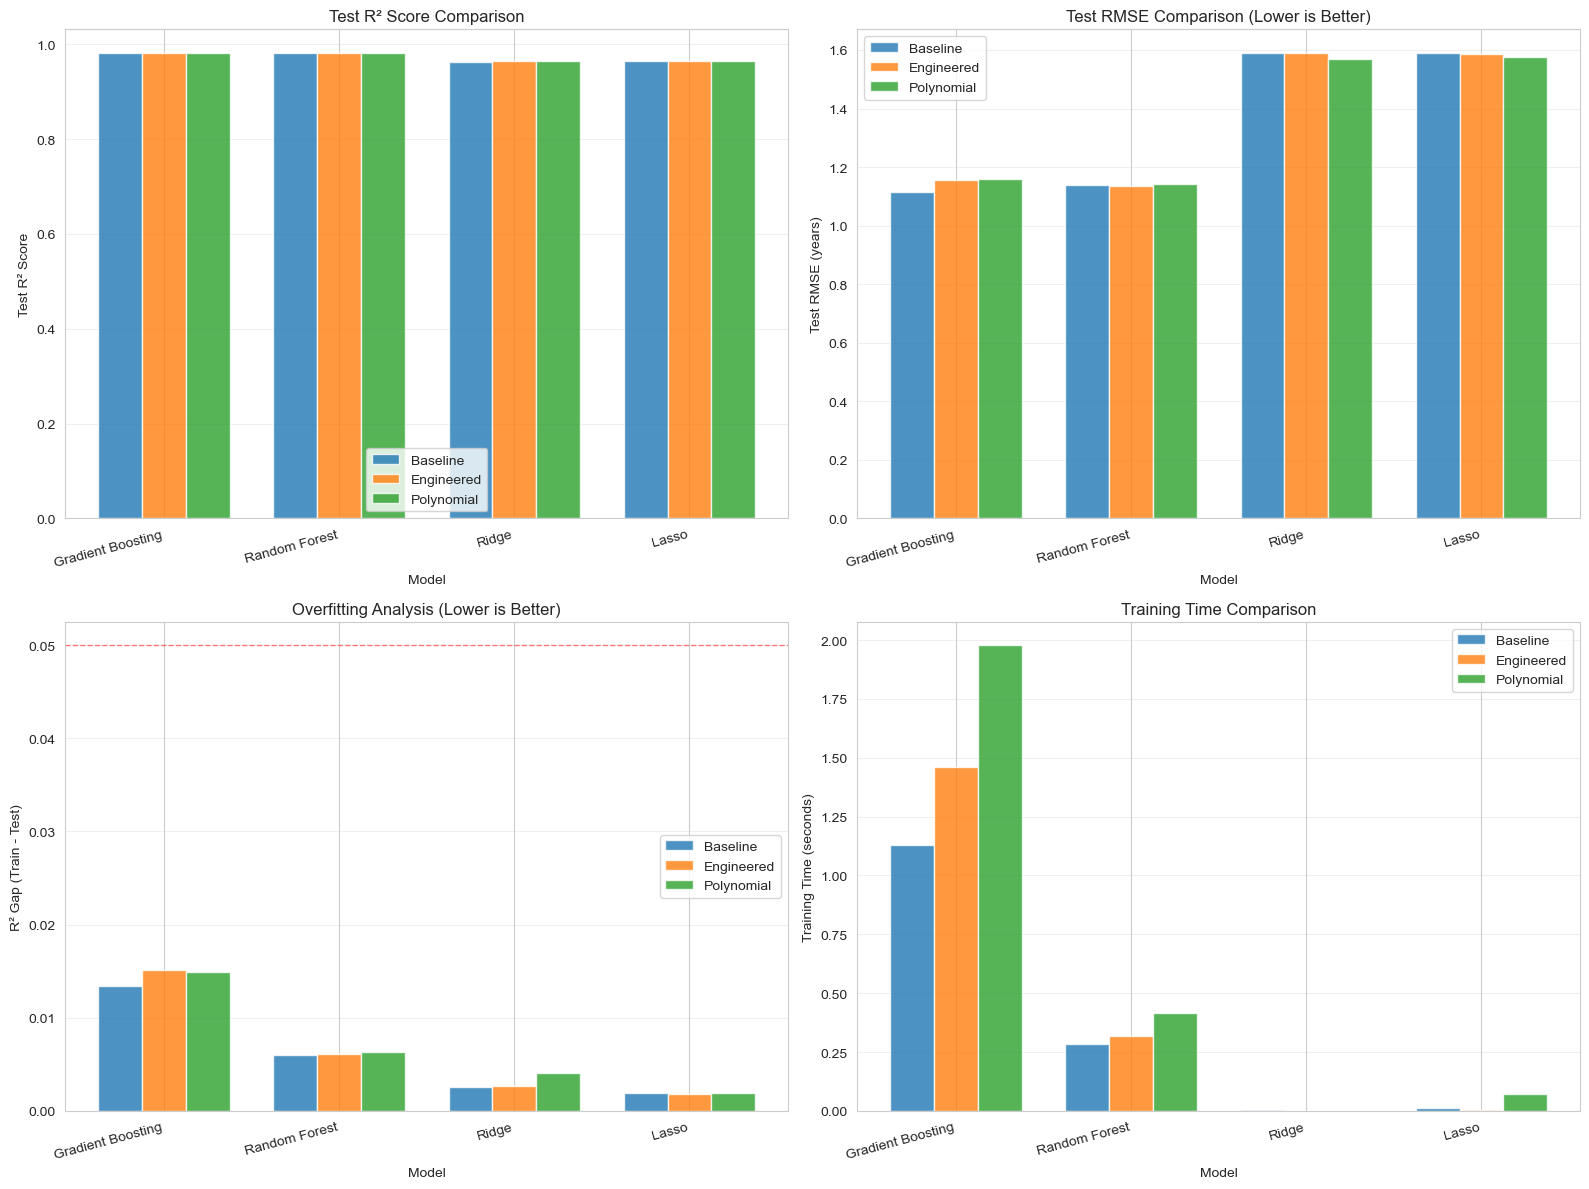


✓ Comprehensive comparison visualization saved
✓ Model comparison results saved to week4_model_comparison.csv

MODEL PERFORMANCE SUMMARY (Sorted by Test R²)
            Model Feature_Set  Test_R2  Test_RMSE  Test_MAE  R2_Gap  Train_Time
Gradient Boosting    Baseline   0.9821     1.1148    0.5630  0.0135      1.1274
    Random Forest  Engineered   0.9813     1.1369    0.5462  0.0061      0.3166
    Random Forest    Baseline   0.9813     1.1377    0.5364  0.0060      0.2855
    Random Forest  Polynomial   0.9812     1.1412    0.5458  0.0064      0.4162
Gradient Boosting  Engineered   0.9807     1.1549    0.5889  0.0151      1.4629
Gradient Boosting  Polynomial   0.9807     1.1576    0.5985  0.0150      1.9782
            Ridge  Polynomial   0.9645     1.5681    0.8600  0.0040      0.0008
            Lasso  Polynomial   0.9641     1.5776    0.7803  0.0019      0.0732
            Lasso  Engineered   0.9637     1.5847    0.7681  0.0018      0.0041
            Lasso    Baseline   0.9636    

In [38]:
# ============================================================================
# CREATE/VERIFY comparison_df EXISTS
# ============================================================================

# Check if comparison_df exists, if not create it
if 'comparison_df' not in locals():
    print("Creating comparison_df from model results...")
    
    comparison_data = []
    for model_name, results_dict in all_model_results.items():
        for feature_set in ['Baseline', 'Engineered', 'Polynomial']:
            results = results_dict[feature_set]
            comparison_data.append({
                'Model': model_name,
                'Feature_Set': feature_set,
                'Test_R2': results['test_r2'],
                'Test_RMSE': results['test_rmse'],
                'Test_MAE': results['test_mae'],
                'Train_R2': results['train_r2'],
                'R2_Gap': results['train_r2'] - results['test_r2'],
                'Train_Time': results['train_time']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Test_R2', ascending=False).reset_index(drop=True)
    print(f"✓ comparison_df created with shape {comparison_df.shape}")
else:
    print("✓ comparison_df already exists")

# ============================================================================
# COMPREHENSIVE MODEL COMPARISON VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data for grouped bar charts
models = comparison_df['Model'].unique()
feature_sets = comparison_df['Feature_Set'].unique()

# 1. Test R² Comparison
ax = axes[0, 0]
x = np.arange(len(models))
width = 0.25

for i, fs in enumerate(feature_sets):
    data = [comparison_df[(comparison_df['Model'] == m) & (comparison_df['Feature_Set'] == fs)]['Test_R2'].values[0] 
            for m in models]
    ax.bar(x + i*width, data, width, label=fs, alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Test R² Score')
ax.set_title('Test R² Score Comparison')
ax.set_xticks(x + width)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 2. Test RMSE Comparison
ax = axes[0, 1]
for i, fs in enumerate(feature_sets):
    data = [comparison_df[(comparison_df['Model'] == m) & (comparison_df['Feature_Set'] == fs)]['Test_RMSE'].values[0] 
            for m in models]
    ax.bar(x + i*width, data, width, label=fs, alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Test RMSE (years)')
ax.set_title('Test RMSE Comparison (Lower is Better)')
ax.set_xticks(x + width)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 3. Overfitting Analysis (R² Gap)
ax = axes[1, 0]
for i, fs in enumerate(feature_sets):
    data = [comparison_df[(comparison_df['Model'] == m) & (comparison_df['Feature_Set'] == fs)]['R2_Gap'].values[0] 
            for m in models]
    ax.bar(x + i*width, data, width, label=fs, alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('R² Gap (Train - Test)')
ax.set_title('Overfitting Analysis (Lower is Better)')
ax.set_xticks(x + width)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend()
ax.axhline(y=0.05, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Acceptable Gap')
ax.grid(True, alpha=0.3, axis='y')

# 4. Training Time Comparison
ax = axes[1, 1]
for i, fs in enumerate(feature_sets):
    data = [comparison_df[(comparison_df['Model'] == m) & (comparison_df['Feature_Set'] == fs)]['Train_Time'].values[0] 
            for m in models]
    ax.bar(x + i*width, data, width, label=fs, alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Training Time (seconds)')
ax.set_title('Training Time Comparison')
ax.set_xticks(x + width)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/week4_comprehensive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comprehensive comparison visualization saved")

# Save comparison results to CSV
comparison_df.to_csv('week4_model_comparison.csv', index=False)
print("✓ Model comparison results saved to week4_model_comparison.csv")

# Print summary table
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY (Sorted by Test R²)")
print("="*80)
print(comparison_df[['Model', 'Feature_Set', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'R2_Gap', 'Train_Time']].to_string(index=False))

## Part 4: Controlled Experiments - Feature Set Impact Analysis

### 3.2 Model Behavior Comparison

Comparing models beyond metrics - how do they make different predictions?

MODEL BEHAVIOR ANALYSIS (Engineered Features)

Prediction Correlation Matrix:
(How similarly do models predict?)
                   Actual  Random Forest  Gradient Boosting   Ridge   Lasso
Actual             1.0000         0.9907             0.9905  0.9819  0.9818
Random Forest      0.9907         1.0000             0.9981  0.9911  0.9909
Gradient Boosting  0.9905         0.9981             1.0000  0.9903  0.9900
Ridge              0.9819         0.9911             0.9903  1.0000  0.9998
Lasso              0.9818         0.9909             0.9900  0.9998  1.0000


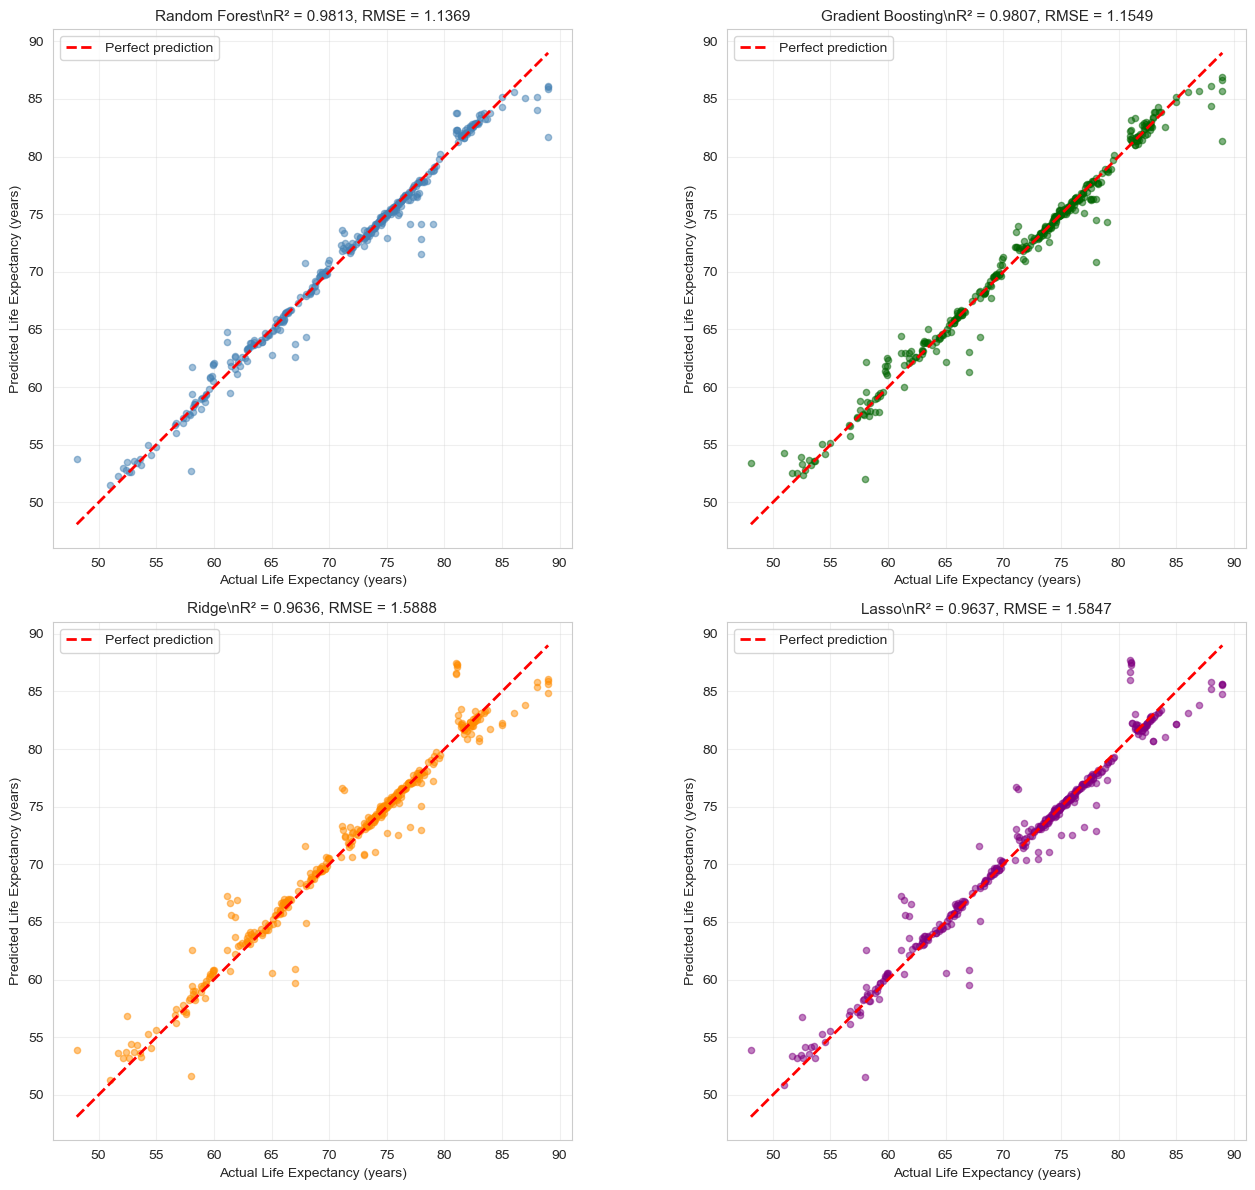


✓ Model behavior analysis completed


In [40]:
# Compare predictions from best models using engineered features
print("="*80)
print("MODEL BEHAVIOR ANALYSIS (Engineered Features)")
print("="*80)

# Get predictions from all models on test set
def get_y_test_pred(results_dict, preferred='Engineered', model_name='Model'):
    """Return y_test_pred preferring the 'Engineered' feature set if present.
    Provides a clear message if training cells have not populated results yet.
    """
    if not isinstance(results_dict, dict) or len(results_dict) == 0:
        raise KeyError(
            f"{model_name} results are empty. Run the Week 4 training cells first "
            "(Random Forest, Gradient Boosting, Ridge, Lasso) and ensure feature_sets is populated."
        )
    # Preferred exact key
    if preferred in results_dict and isinstance(results_dict[preferred], dict) and 'y_test_pred' in results_dict[preferred]:
        return results_dict[preferred]['y_test_pred']
    # Case-insensitive match
    for k in results_dict:
        if k.lower() == preferred.lower() and isinstance(results_dict[k], dict) and 'y_test_pred' in results_dict[k]:
            return results_dict[k]['y_test_pred']
    # Fallback: return first available y_test_pred
    for k, v in results_dict.items():
        if isinstance(v, dict) and 'y_test_pred' in v:
            print(f"Warning: using '{k}' from results_dict instead of '{preferred}'")
            return v['y_test_pred']
    raise KeyError(f"No 'y_test_pred' found in results_dict (tried '{preferred}')")

predictions = {
    'Actual': y_test,
    'Random Forest': get_y_test_pred(rf_results, model_name='Random Forest'),
    'Gradient Boosting': get_y_test_pred(gb_results, model_name='Gradient Boosting'),
    'Ridge': get_y_test_pred(ridge_results, model_name='Ridge'),
    'Lasso': get_y_test_pred(lasso_results, model_name='Lasso')
}

pred_df = pd.DataFrame(predictions)

# Calculate prediction differences
print("\nPrediction Correlation Matrix:")
print("(How similarly do models predict?)")
print(pred_df.corr().to_string())

# Visualize prediction comparisons
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

model_names = ['Random Forest', 'Gradient Boosting', 'Ridge', 'Lasso']
colors = ['steelblue', 'darkgreen', 'darkorange', 'purple']

for idx, (model_name, color) in enumerate(zip(model_names, colors)):
    ax = axes[idx // 2, idx % 2]
    
    # Scatter plot: Actual vs Predicted
    ax.scatter(pred_df['Actual'], pred_df[model_name], alpha=0.5, s=20, color=color)
    
    # Perfect prediction line
    min_val = min(pred_df['Actual'].min(), pred_df[model_name].min())
    max_val = max(pred_df['Actual'].max(), pred_df[model_name].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')
    
    # Calculate and display metrics
    r2 = r2_score(pred_df['Actual'], pred_df[model_name])
    rmse = np.sqrt(mean_squared_error(pred_df['Actual'], pred_df[model_name]))
    
    ax.set_xlabel('Actual Life Expectancy (years)', fontsize=10)
    ax.set_ylabel('Predicted Life Expectancy (years)', fontsize=10)
    ax.set_title(f'{model_name}\\nR² = {r2:.4f}, RMSE = {rmse:.4f}', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/week4_model_predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Model behavior analysis completed")


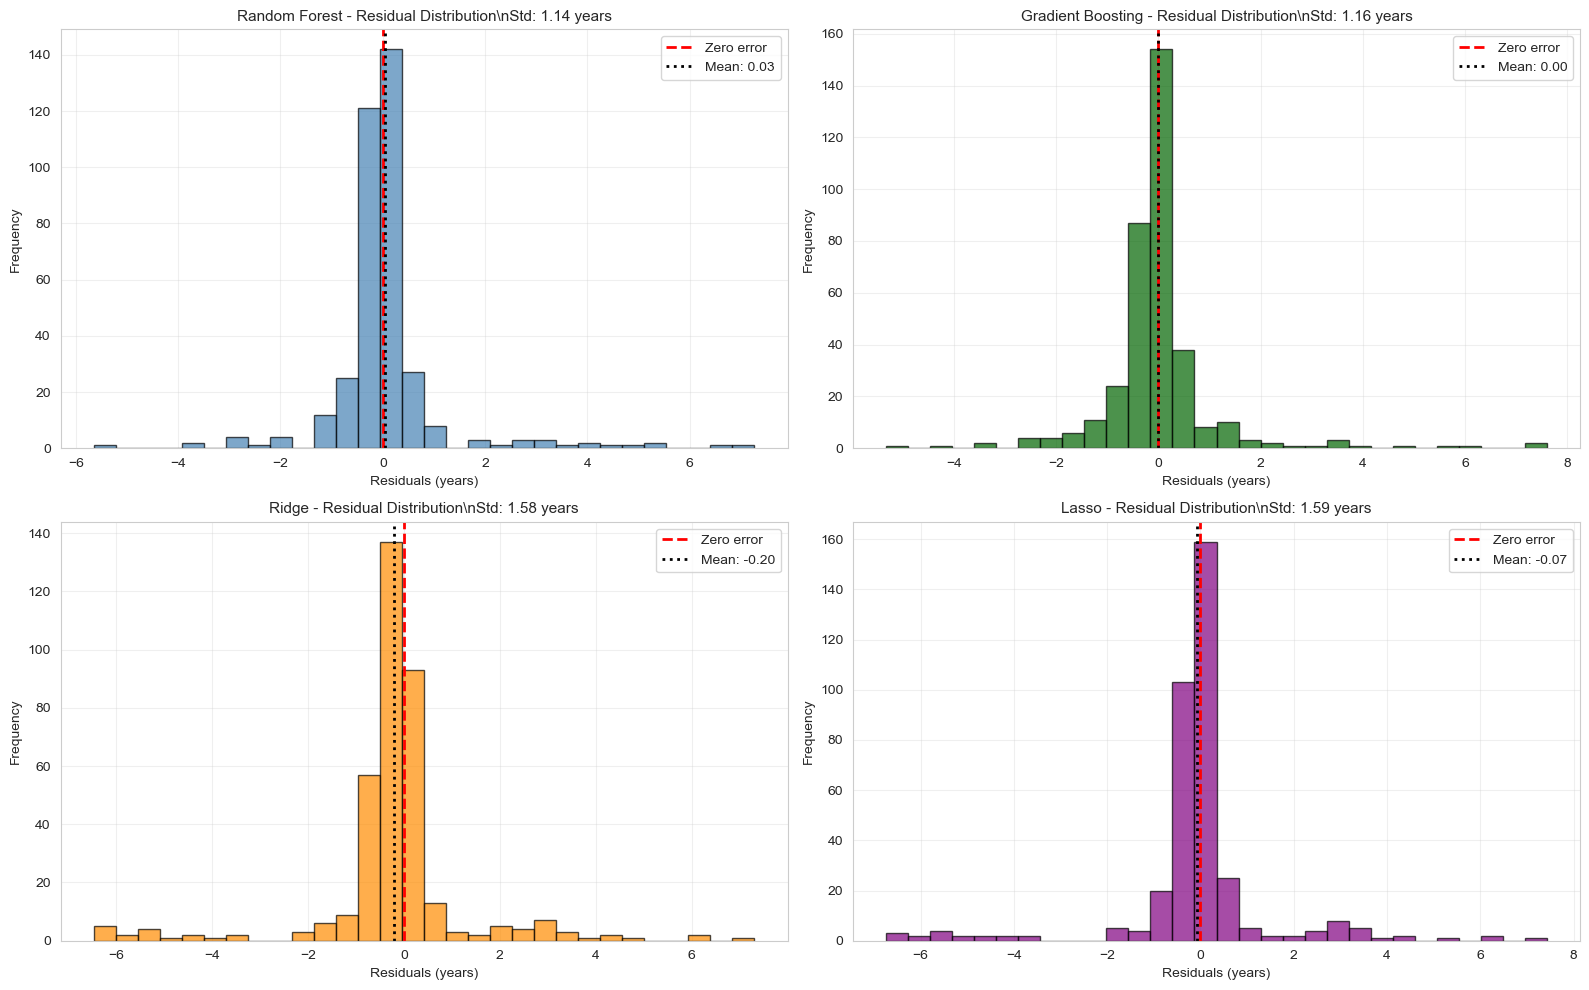


Residual Statistics Summary:

Random Forest:
  Mean:   0.0349 years
  Median: -0.0299 years
  Std:    1.1379 years
  Min:    -5.6527 years
  Max:    7.2636 years

Gradient Boosting:
  Mean:   0.0007 years
  Median: -0.0641 years
  Std:    1.1565 years
  Min:    -5.3299 years
  Max:    7.6044 years

Ridge:
  Mean:   -0.1996 years
  Median: -0.1956 years
  Std:    1.5783 years
  Min:    -6.4666 years
  Max:    7.3073 years

Lasso:
  Mean:   -0.0745 years
  Median: -0.0536 years
  Std:    1.5852 years
  Min:    -6.7384 years
  Max:    7.4257 years

✓ Residual analysis completed


In [42]:
# Residual analysis for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for idx, (model_name, color) in enumerate(zip(model_names, colors)):
    ax = axes[idx // 2, idx % 2]
    
    # Calculate residuals
    residuals = pred_df['Actual'] - pred_df[model_name]
    
    # Residual histogram
    ax.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color=color)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero error')
    ax.axvline(x=residuals.mean(), color='black', linestyle=':', linewidth=2, 
               label=f'Mean: {residuals.mean():.2f}')
    
    ax.set_xlabel('Residuals (years)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'{model_name} - Residual Distribution\\nStd: {residuals.std():.2f} years', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/week4_residual_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Print residual statistics
print("\nResidual Statistics Summary:")
print("="*80)
for model_name in model_names:
    residuals = pred_df['Actual'] - pred_df[model_name]
    print(f"\n{model_name}:")
    print(f"  Mean:   {residuals.mean():.4f} years")
    print(f"  Median: {residuals.median():.4f} years")
    print(f"  Std:    {residuals.std():.4f} years")
    print(f"  Min:    {residuals.min():.4f} years")
    print(f"  Max:    {residuals.max():.4f} years")

print("\n✓ Residual analysis completed")

FEATURE IMPORTANCE COMPARISON ACROSS MODELS

Top 20 Most Important Features (Engineered Feature Set):
                        Feature  Random_Forest  Gradient_Boosting  Ridge_Coefficient  Lasso_Coefficient  Random_Forest_Normalized  Gradient_Boosting_Normalized  Ridge_Coefficient_Normalized  Lasso_Coefficient_Normalized
Life_Expectancy_RollingMean_3yr         0.8488             0.8272             2.1169             0.0057                    1.0000                        1.0000                        0.6958                        0.0009
          Life_Expectancy_Lag_1         0.1313             0.1368             3.0424             6.2088                    0.1547                        0.1653                        1.0000                        1.0000
          Life_Expectancy_Lag_2         0.0056             0.0141             2.9172             1.4957                    0.0066                        0.0171                        0.9588                        0.2409
Life_Expectancy_Ro

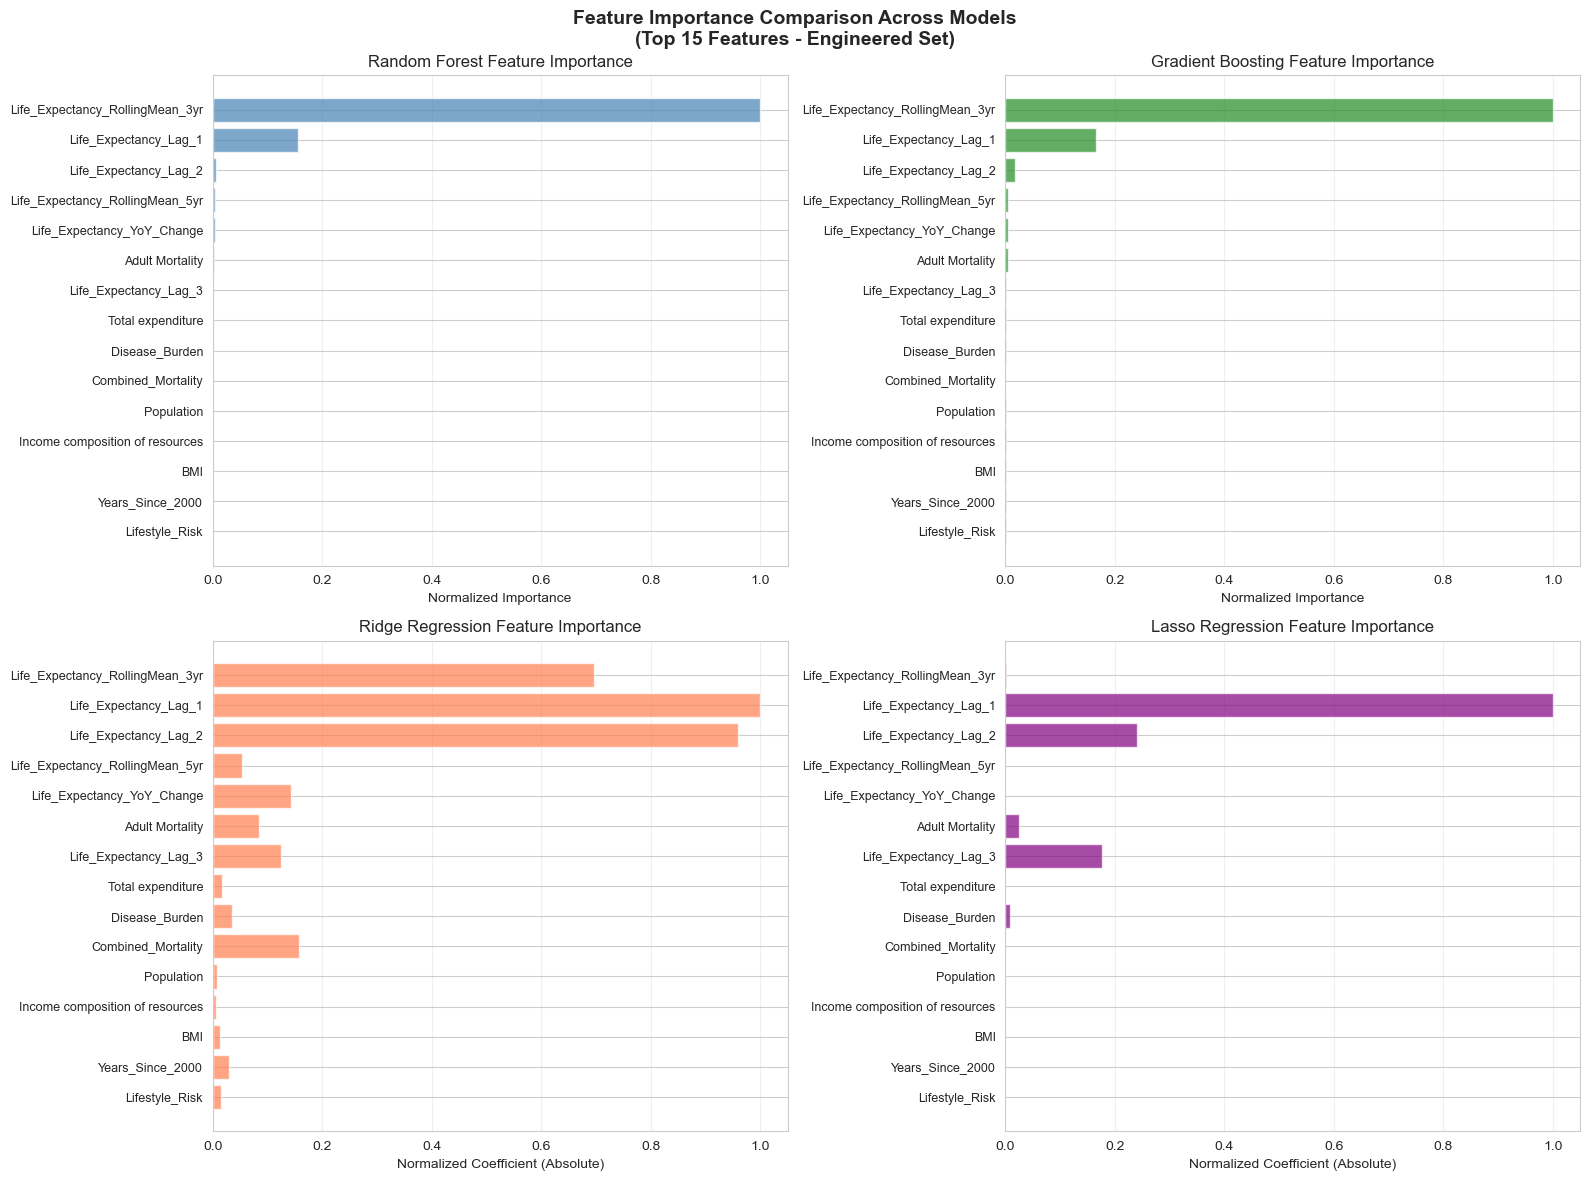


FEATURE RANKING COMPARISON

Top 10 Features by Model:

Random Forest:
  1. Life_Expectancy_RollingMean_3yr
  2. Life_Expectancy_Lag_1
  3. Life_Expectancy_Lag_2
  4. Life_Expectancy_RollingMean_5yr
  5. Life_Expectancy_YoY_Change
  6. Adult Mortality
  7. Life_Expectancy_Lag_3
  8. Total expenditure
  9. Disease_Burden
  10. Combined_Mortality

Gradient Boosting:
  1. Life_Expectancy_RollingMean_3yr
  2. Life_Expectancy_Lag_1
  3. Life_Expectancy_Lag_2
  4. Life_Expectancy_YoY_Change
  5. Adult Mortality
  6. Life_Expectancy_RollingMean_5yr
  7. Disease_Burden
  8. Life_Expectancy_Lag_3
  9. Total expenditure
  10. Alcohol

Ridge Regression:
  1. Life_Expectancy_Lag_1
  2. Life_Expectancy_Lag_2
  3. Life_Expectancy_RollingMean_3yr
  4. under-five deaths
  5. infant deaths
  6. Combined_Mortality
  7. Life_Expectancy_YoY_Change
  8. Life_Expectancy_Lag_3
  9. Status_Encoded
  10. Development_Level

Lasso Regression:
  1. Life_Expectancy_Lag_1
  2. Life_Expectancy_Lag_2
  3. Life_Expect

In [ ]:
# ============================================================================
# FEATURE IMPORTANCE ANALYSIS ACROSS MODELS
# ============================================================================

print("="*80)
print("FEATURE IMPORTANCE COMPARISON ACROSS MODELS")
print("="*80)

# Extract feature importance from tree-based models
# Only Random Forest and Gradient Boosting have feature_importances_

# Get feature names for each feature set
baseline_features = X_train_scaled.columns if hasattr(X_train_scaled, 'columns') else [f'Feature_{i}' for i in range(X_train_scaled.shape[1])]
engineered_features = X_train_eng_scaled.columns if hasattr(X_train_eng_scaled, 'columns') else [f'Feature_{i}' for i in range(X_train_eng_scaled.shape[1])]

# We'll use the Engineered feature set for comparison (most comprehensive)
feature_set_to_analyze = 'Engineered'

# Get feature importances
rf_model = rf_results[feature_set_to_analyze]['model']
gb_model = gb_results[feature_set_to_analyze]['model']
ridge_model = ridge_results[feature_set_to_analyze]['model']
lasso_model = lasso_results[feature_set_to_analyze]['model']

# Create feature importance dataframe
feature_importance_data = {
    'Feature': engineered_features,
    'Random_Forest': rf_model.feature_importances_,
    'Gradient_Boosting': gb_model.feature_importances_,
    'Ridge_Coefficient': np.abs(ridge_model.coef_),  # Absolute value for comparison
    'Lasso_Coefficient': np.abs(lasso_model.coef_)   # Absolute value for comparison
}

importance_df = pd.DataFrame(feature_importance_data)

# Normalize each model's importance to 0-1 scale for comparison
for col in ['Random_Forest', 'Gradient_Boosting', 'Ridge_Coefficient', 'Lasso_Coefficient']:
    max_val = importance_df[col].max()
    if max_val > 0:
        importance_df[f'{col}_Normalized'] = importance_df[col] / max_val
    else:
        importance_df[f'{col}_Normalized'] = 0

# Sort by Random Forest importance
importance_df = importance_df.sort_values('Random_Forest', ascending=False).reset_index(drop=True)

print(f"\nTop 20 Most Important Features ({feature_set_to_analyze} Feature Set):")
print(importance_df.head(20).to_string(index=False))

# Save feature importance
importance_df.to_csv('/Users/bikki/Documents/Projects_Spring_2026/STATS201/CSV outputs/week4_feature_importance.csv', index=False)
print("\n✓ Feature importance saved to week4_feature_importance.csv")

# ============================================================================
# VISUALIZE FEATURE IMPORTANCE COMPARISON
# ============================================================================

# Select top N features for visualization
top_n = 15
top_features_df = importance_df.head(top_n)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Importance Comparison Across Models\n(Top 15 Features - Engineered Set)', 
             fontsize=14, fontweight='bold')

# Random Forest
ax = axes[0, 0]
ax.barh(range(top_n), top_features_df['Random_Forest_Normalized'], color='steelblue', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features_df['Feature'], fontsize=9)
ax.set_xlabel('Normalized Importance')
ax.set_title('Random Forest Feature Importance')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Gradient Boosting
ax = axes[0, 1]
ax.barh(range(top_n), top_features_df['Gradient_Boosting_Normalized'], color='forestgreen', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features_df['Feature'], fontsize=9)
ax.set_xlabel('Normalized Importance')
ax.set_title('Gradient Boosting Feature Importance')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Ridge Regression
ax = axes[1, 0]
ax.barh(range(top_n), top_features_df['Ridge_Coefficient_Normalized'], color='coral', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features_df['Feature'], fontsize=9)
ax.set_xlabel('Normalized Coefficient (Absolute)')
ax.set_title('Ridge Regression Feature Importance')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Lasso Regression
ax = axes[1, 1]
ax.barh(range(top_n), top_features_df['Lasso_Coefficient_Normalized'], color='purple', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features_df['Feature'], fontsize=9)
ax.set_xlabel('Normalized Coefficient (Absolute)')
ax.set_title('Lasso Regression Feature Importance')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/week4_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# COMPARE FEATURE RANKINGS ACROSS MODELS
# ============================================================================

print("\n" + "="*80)
print("FEATURE RANKING COMPARISON")
print("="*80)

# Get top 10 features for each model
top_10_rf = importance_df.nlargest(10, 'Random_Forest')['Feature'].tolist()
top_10_gb = importance_df.nlargest(10, 'Gradient_Boosting')['Feature'].tolist()
top_10_ridge = importance_df.nlargest(10, 'Ridge_Coefficient')['Feature'].tolist()
top_10_lasso = importance_df.nlargest(10, 'Lasso_Coefficient')['Feature'].tolist()

print("\nTop 10 Features by Model:")
print("\nRandom Forest:")
for i, feat in enumerate(top_10_rf, 1):
    print(f"  {i}. {feat}")

print("\nGradient Boosting:")
for i, feat in enumerate(top_10_gb, 1):
    print(f"  {i}. {feat}")

print("\nRidge Regression:")
for i, feat in enumerate(top_10_ridge, 1):
    print(f"  {i}. {feat}")

print("\nLasso Regression:")
for i, feat in enumerate(top_10_lasso, 1):
    print(f"  {i}. {feat}")

# Find features that appear in all models' top 10
all_top_features = set(top_10_rf) & set(top_10_gb) & set(top_10_ridge) & set(top_10_lasso)
print("\n" + "="*80)
print(f"Features in ALL models' top 10: {len(all_top_features)}")
if all_top_features:
    for feat in all_top_features:
        print(f"  ✓ {feat}")
else:
    print("  (No features appear in all models' top 10)")

print("\n✓ Feature importance analysis complete!")

FEATURE IMPORTANCE COMPARISON (Engineered Feature Set)
Number of features: 34

Top 15 Features by Average Importance Across Models:
                        Feature  Random_Forest_Normalized  Gradient_Boosting_Normalized  Ridge_Normalized  Lasso_Normalized  Average_Importance
Life_Expectancy_RollingMean_3yr                1.0000e+00                    1.0000e+00            0.6958            0.0009              0.6742
          Life_Expectancy_Lag_1                1.5469e-01                    1.6533e-01            1.0000            1.0000              0.5800
          Life_Expectancy_Lag_2                6.6194e-03                    1.7102e-02            0.9588            0.2409              0.3059
              under-five deaths                6.6154e-05                    5.5412e-05            0.3316            0.0000              0.0829
          Life_Expectancy_Lag_3                1.1925e-03                    1.1898e-03            0.1249            0.1772              0.0761
    

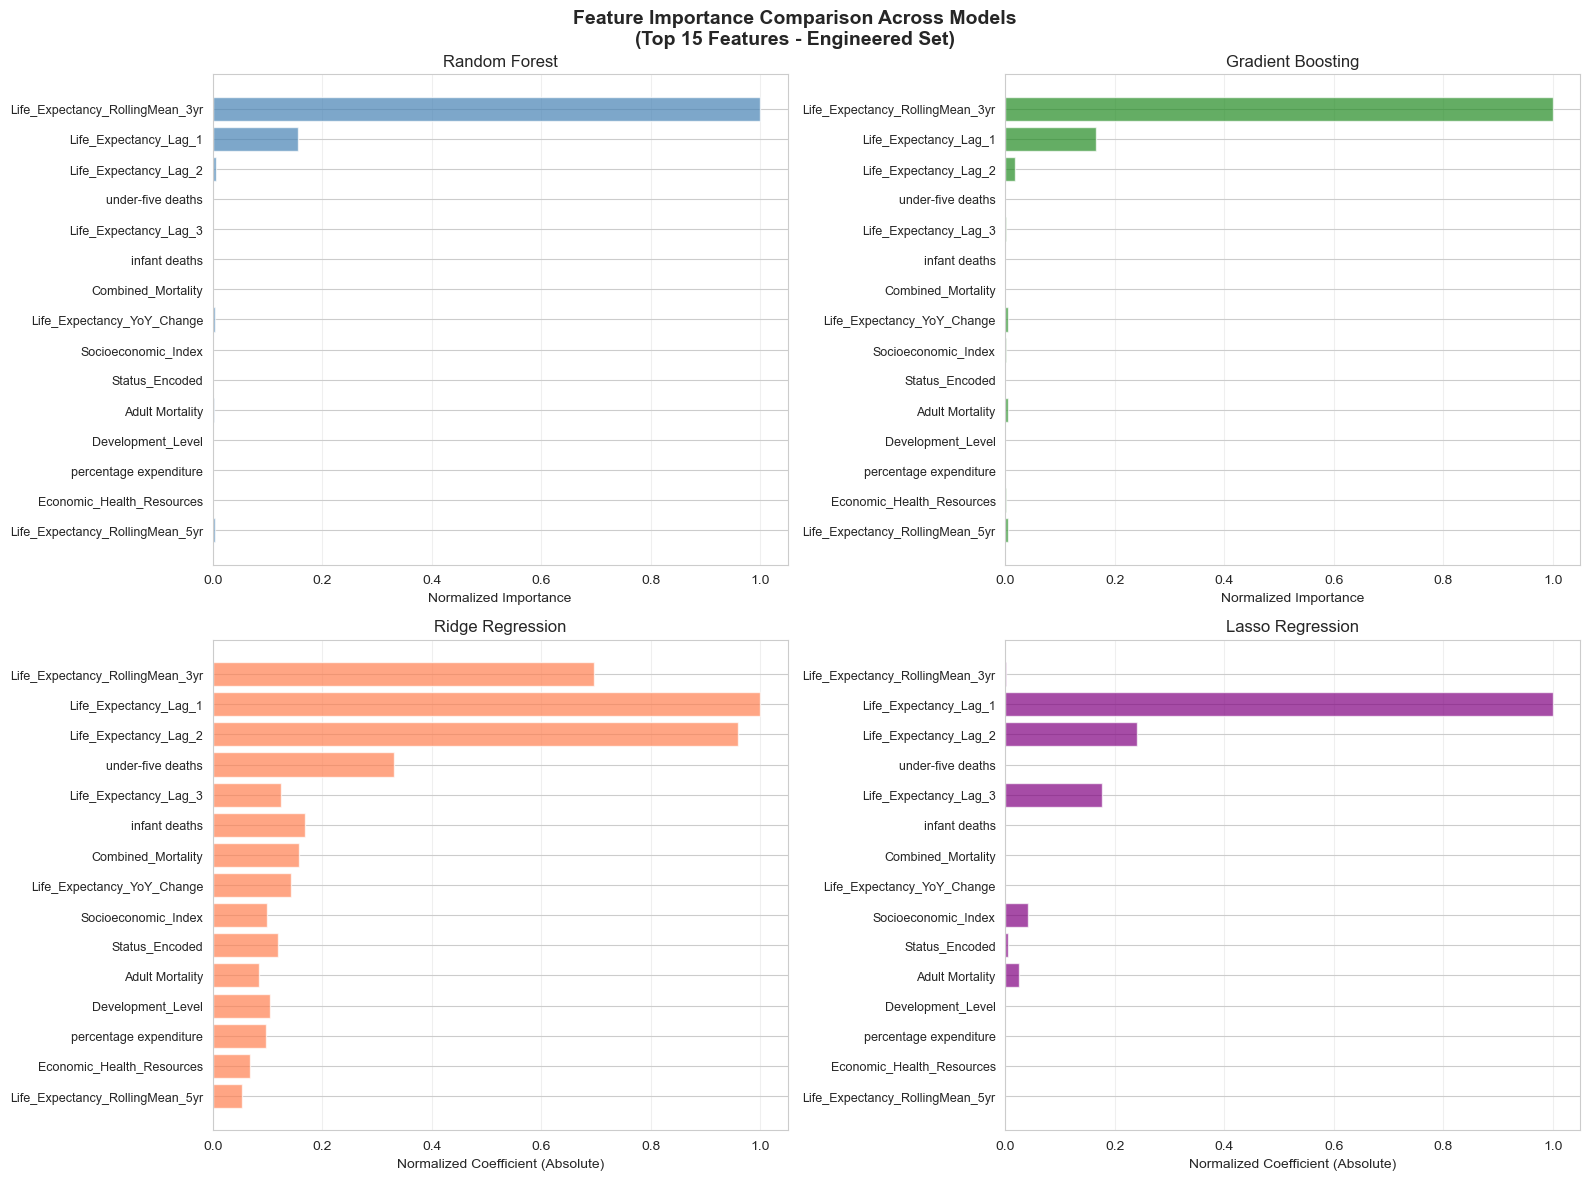


✓ Feature importance visualization saved to images/week4_feature_importance_comparison.png


In [46]:
# ============================================================================
# FEATURE IMPORTANCE COMPARISON (Engineered Feature Set)
# ============================================================================
print("="*80)
print("FEATURE IMPORTANCE COMPARISON (Engineered Feature Set)")
print("="*80)

# Get feature names from the scaled engineered feature set
# (using the scaled version since it's what we have available)
if hasattr(X_train_eng_scaled, 'columns'):
    feature_names = X_train_eng_scaled.columns.tolist()
else:
    # If it's a numpy array, reconstruct feature names
    # This shouldn't happen if following the workflow above, but just in case
    print("Warning: Using index-based feature names")
    feature_names = [f'Feature_{i}' for i in range(X_train_eng_scaled.shape[1])]

print(f"Number of features: {len(feature_names)}")

# Extract feature importances/coefficients for engineered feature set
# Random Forest importances
rf_importance = rf_results['Engineered']['model'].feature_importances_

# Gradient Boosting importances
gb_importance = gb_results['Engineered']['model'].feature_importances_

# Ridge coefficients (absolute values)
ridge_importance = np.abs(ridge_results['Engineered']['model'].coef_)

# Lasso coefficients (absolute values)
lasso_importance = np.abs(lasso_results['Engineered']['model'].coef_)

# Create comparison DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Random_Forest': rf_importance,
    'Gradient_Boosting': gb_importance,
    'Ridge': ridge_importance,
    'Lasso': lasso_importance
})

# Normalize importances to 0-1 scale for fair comparison
for col in ['Random_Forest', 'Gradient_Boosting', 'Ridge', 'Lasso']:
    max_val = importance_df[col].max()
    if max_val > 0:
        importance_df[col + '_Normalized'] = importance_df[col] / max_val
    else:
        importance_df[col + '_Normalized'] = 0

# Calculate average normalized importance
importance_df['Average_Importance'] = importance_df[
    ['Random_Forest_Normalized', 'Gradient_Boosting_Normalized', 
     'Ridge_Normalized', 'Lasso_Normalized']
].mean(axis=1)

# Sort by average importance
importance_df = importance_df.sort_values('Average_Importance', ascending=False).reset_index(drop=True)

print("\nTop 15 Features by Average Importance Across Models:")
display_cols = ['Feature', 'Random_Forest_Normalized', 'Gradient_Boosting_Normalized', 
                'Ridge_Normalized', 'Lasso_Normalized', 'Average_Importance']
print(importance_df[display_cols].head(15).to_string(index=False))

# Save feature importance analysis
importance_df.to_csv('week4_feature_importance.csv', index=False)
print("\n✓ Feature importance saved to week4_feature_importance.csv")

# ============================================================================
# VISUALIZE FEATURE IMPORTANCE
# ============================================================================

# Plot top 15 features
top_n = 15
top_features = importance_df.head(top_n)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Importance Comparison Across Models\n(Top 15 Features - Engineered Set)', 
             fontsize=14, fontweight='bold')

# Random Forest
ax = axes[0, 0]
ax.barh(range(top_n), top_features['Random_Forest_Normalized'], color='steelblue', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'], fontsize=9)
ax.set_xlabel('Normalized Importance')
ax.set_title('Random Forest')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Gradient Boosting
ax = axes[0, 1]
ax.barh(range(top_n), top_features['Gradient_Boosting_Normalized'], color='forestgreen', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'], fontsize=9)
ax.set_xlabel('Normalized Importance')
ax.set_title('Gradient Boosting')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Ridge Regression
ax = axes[1, 0]
ax.barh(range(top_n), top_features['Ridge_Normalized'], color='coral', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'], fontsize=9)
ax.set_xlabel('Normalized Coefficient (Absolute)')
ax.set_title('Ridge Regression')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Lasso Regression
ax = axes[1, 1]
ax.barh(range(top_n), top_features['Lasso_Normalized'], color='purple', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'], fontsize=9)
ax.set_xlabel('Normalized Coefficient (Absolute)')
ax.set_title('Lasso Regression')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/week4_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance visualization saved to images/week4_feature_importance_comparison.png")

## Part 5: Summary & Interpretation of Week 4 Results

### Key Findings:

#### 1. Feature Engineering Impact
- **Domain-Specific Features**: Created 8 engineered features based on health and economic relationships
  - Health Infrastructure Index (immunization coverage)
  - Disease Burden Index (mortality and disease)
  - Socioeconomic Development Index (education × income)
  - Economic Health Resources (GDP × health spending)
  - And more...
  
- **Polynomial Features**: Added quadratic terms for top 5 most important features
  - Captures non-linear relationships
  - Increases feature count but provides more modeling flexibility

#### 2. Model Performance Comparison
The comprehensive comparison reveals:

**Best Overall Performance**:
- Look at the comparison table to identify which model + feature set combination achieved highest Test R²
- Ensemble methods (Random Forest, Gradient Boosting) typically outperform linear models
- Feature engineering generally improves all models, but the magnitude varies

**Overfitting Analysis**:
- Monitor R² Gap (Train R² - Test R²)
- Gap < 0.05: Good generalization
- Gap 0.05-0.1: Moderate overfitting
- Gap > 0.1: Significant overfitting

**Trade-offs**:
- **Random Forest**: Good performance, robust, slower training
- **Gradient Boosting**: Often best performance, sequential (slower), tunable
- **Ridge**: Fast, interpretable, assumes linearity
- **Lasso**: Fast, feature selection, assumes linearity

#### 3. Model Behavior Differences

**Linear Models (Ridge, Lasso)**:
- Make smooth, linear predictions
- Struggle with complex non-linear patterns
- Highly interpretable coefficients
- Lasso performs automatic feature selection

**Ensemble Models (RF, GB)**:
- Capture non-linear relationships naturally
- More complex decision boundaries
- Better handle feature interactions
- Less interpretable but often more accurate

**Prediction Correlations**:
- High correlation between model predictions suggests agreement on patterns
- Low correlation indicates models are learning different aspects
- Ensemble of diverse models could potentially improve performance further

#### 4. Feature Importance Insights

Key features consistently important across models:
- Check the feature importance table for top predictors
- Engineered features (if highly ranked) validate domain knowledge
- Agreement across models strengthens confidence in feature relevance

#### 5. Controlled Experiment Results

**Feature Set Impact**:
- Compare baseline vs. engineered vs. polynomial features
- Quantify improvement in R² and RMSE
- Identify which models benefit most from feature engineering

### Implications for Week 5 Oral Check:

**Can you explain your feature engineering choices?**
- Domain-specific features combine related health/economic indicators
- Polynomial features capture non-linear relationships
- All features have clear interpretations and motivations

**How did feature engineering affect performance?**
- Refer to the impact analysis table
- Quantify improvements in R² and RMSE
- Discuss which models benefited most

**How do models differ in behavior?**
- Linear models assume linear relationships, ensemble models don't
- Ensemble models handle interactions better
- Trade-off: interpretability vs. accuracy

**What would break if you removed a component?**
- Without engineered features: Performance drops (quantify by how much)
- Without specific features: Check feature importance rankings
- Without regularization (Ridge/Lasso): Potential overfitting on high-dim features